
# Road Accident Severity Prediction —  Notebook
**Full pipeline (EDA, feature engineering, modeling, comparison, SHAP)**



In [ ]:

!pip install -q xgboost shap pyarrow imbalanced-learn joblib prophet

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from pathlib import Path
import joblib, json, os, time

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.inspection import PartialDependenceDisplay

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

try:
    import shap
except:
    shap = None

try:
    from sklearn.cluster import DBSCAN
except:
    DBSCAN = None

try:
    from prophet import Prophet
except:
    Prophet = None

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_DIR = Path("/content")
TRAIN_PQ = DATA_DIR / "train.parquet"
TEST_PQ  = DATA_DIR / "test.parquet"

ARTIFACTS = DATA_DIR / "artifacts_inline"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

SAVE_ARTIFACTS = True

print("DATA_DIR:", DATA_DIR)
print("Train present?", TRAIN_PQ.exists())
print("Test present?", TEST_PQ.exists())


DATA_DIR: \content
Train present? True
Test present? True


In [ ]:

# 1. Load data
train = pd.read_parquet(TRAIN_PQ)
test  = pd.read_parquet(TEST_PQ)
print('Train shape:', train.shape)
print('Test shape:', test.shape)
display(train.head(15))


Train shape: (2436610, 25)
Test shape: (1457237, 25)


,collision_index,vehicle_type,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,age_of_vehicle,longitude,latitude,collision_severity,...,weather_conditions,road_surface_conditions,urban_or_rural_area,collision_year,year,month,hour,weather_simple,is_wet,severity_label
0,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,1,1,1,2016,2016,4,8,1,0,3.0
1,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,1,1,1,2016,2016,4,8,1,0,3.0
2,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,1,1,1,2016,2016,4,8,1,0,3.0
3,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,1,1,1,2016,2016,4,8,1,0,3.0
4,2016460051223,8,1,50.0,8,1598.0,5.0,0.290739,51.205272,3,...,1,2,1,2016,2016,9,19,1,0,3.0
5,2017134310640,9,2,27.0,6,1796.0,13.0,-1.549844,53.743787,2,...,2,2,1,2017,2017,1,12,2,0,2.0
6,2017301700824,9,1,48.0,8,1910.0,10.0,-1.379662,53.301244,3,...,1,1,2,2017,2017,12,6,1,0,3.0
7,2017301700824,9,1,48.0,8,1910.0,10.0,-1.379662,53.301244,3,...,1,1,2,2017,2017,12,6,1,0,3.0
8,2018200324527,19,1,53.0,8,1995.0,10.0,-1.797434,52.511889,3,...,1,1,1,2018,2018,6,18,1,0,3.0
9,2019200831660,5,1,27.0,6,998.0,15.0,-2.019965,52.490026,1,...,1,1,1,2019,2019,10,20,1,0,1.0


In [ ]:
from IPython.display import display, Markdown
# 1.1 Quick checks
for df,name in [(train,'train'), (test,'test')]:
    display(Markdown(f"### {name}"))
    if 'severity_label' in df.columns:
        display(df['severity_label'].value_counts(dropna=False))
    else:
        display(Markdown("- severity_label missing"))
    if 'year' in df.columns:
        try:
            display(Markdown(f"- year range: {int(df['year'].min())} to {int(df['year'].max())}"))
        except Exception:
            display(Markdown("- year column present but non-numeric"))
    elif 'collision_year' in df.columns:
        display(Markdown("- collision_year present"))
    else:
        display(Markdown("- no year column"))


### train

severity_label
3.0    1990798
2.0     405112
1.0      40700
Name: count, dtype: Int64

- year range: 2014 to 2019

### test

severity_label
3.0    1098233
2.0     330277
1.0      28727
Name: count, dtype: Int64

- year range: 2020 to 2024


## 2. Feature engineering
Creates temporal, environmental, vehicle and spatial features with robust casting.


In [ ]:
def safe_feature_engineer(df):
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.day_name()
    elif 'collision_year' in df.columns:
        df['year'] = pd.to_numeric(df['collision_year'], errors='coerce')
    else:
        df['year'] = pd.NA

    if 'time' in df.columns:
        df['time'] = df['time'].astype(str).str.zfill(5).str.slice(0,5)
        df['hour'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.hour
    else:
        df['hour'] = pd.NA

    df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday']).astype(int) if 'day_of_week' in df.columns else 0
    df['is_night'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (x>=20 or x<=5) else 0) if 'hour' in df.columns else 0
    df['rush_hour'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (7<=x<=9 or 16<=x<=18) else 0) if 'hour' in df.columns else 0

    if 'month' in df.columns:
        df['season'] = df['month'].map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn'})

    if 'weather_conditions' in df.columns:
        df['weather_conditions'] = df['weather_conditions'].astype(str).fillna('')
        df['weather_simple'] = df['weather_conditions'].str.lower().apply(
            lambda s: 'rain' if 'rain' in s else ('snow' if 'snow' in s else ('fog' if 'fog' in s or 'mist' in s else ('clear' if 'clear' in s or 'fine' in s else s)))
        )
    if 'road_surface_conditions' in df.columns:
        df['road_surface_conditions'] = df['road_surface_conditions'].astype(str).fillna('')
        df['is_wet'] = df['road_surface_conditions'].str.contains('wet', case=False, na=False).astype(int)

    for c in ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(-1)

    if 'severity_label' not in df.columns and 'collision_severity' in df.columns:

        temp_severity = df['collision_severity'].astype(str).str.strip().str.lower()


        mapping = {'slight':0, 'serious':1, 'fatal':2,
                   '1':0, '2':1, '3':2}

        df['severity_label'] = temp_severity.map(mapping)

        df['severity_label'] = df['severity_label'].fillna(-1).astype(int)

    if 'latitude' in df.columns and 'longitude' in df.columns:
        df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
        df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
        df = df[df['latitude'].between(-90,90) & df['longitude'].between(-180,180)]
        lat0 = df['latitude'].mean()
        lon0 = df['longitude'].mean()
        df['dist_to_center'] = ((df['latitude']-lat0)**2 + (df['longitude']-lon0)**2)**0.5
    else:
        df['dist_to_center'] = -1

    return df

train_fe = safe_feature_engineer(train)
test_fe  = safe_feature_engineer(test)
display(train_fe.head(15))

,collision_index,vehicle_type,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,age_of_vehicle,longitude,latitude,collision_severity,...,hour,weather_simple,is_wet,severity_label,day_of_week,is_weekend,is_night,rush_hour,season,dist_to_center
0,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,8,1,0,3.0,Tuesday,0,0,1,Spring,2.227354
1,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,8,1,0,3.0,Tuesday,0,0,1,Spring,2.227354
2,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,8,1,0,3.0,Tuesday,0,0,1,Spring,2.227354
3,201604WB16044,9,1,36.0,7,1598.0,2.0,-2.881098,54.063227,3,...,8,1,0,3.0,Tuesday,0,0,1,Spring,2.227354
4,2016460051223,8,1,50.0,8,1598.0,5.0,0.290739,51.205272,3,...,19,1,0,3.0,Saturday,1,0,0,Autumn,2.050394
5,2017134310640,9,2,27.0,6,1796.0,13.0,-1.549844,53.743787,2,...,12,2,0,2.0,Tuesday,0,0,0,Winter,1.288532
6,2017301700824,9,1,48.0,8,1910.0,10.0,-1.379662,53.301244,3,...,6,1,0,3.0,Tuesday,0,0,0,Winter,0.827285
7,2017301700824,9,1,48.0,8,1910.0,10.0,-1.379662,53.301244,3,...,6,1,0,3.0,Tuesday,0,0,0,Winter,0.827285
8,2018200324527,19,1,53.0,8,1995.0,10.0,-1.797434,52.511889,3,...,18,1,0,3.0,Friday,0,0,1,Summer,0.480539
9,2019200831660,5,1,27.0,6,998.0,15.0,-2.019965,52.490026,1,...,20,1,0,1.0,Friday,0,1,0,Autumn,0.701881


In [ ]:


CODEBOOK_PATH = "/content/dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024.xlsx"
ARTIFACTS = Path("/content/artifacts_inline") if 'ARTIFACTS' not in globals() else ARTIFACTS
ARTIFACTS.mkdir(parents=True, exist_ok=True)

def build_mappings_from_excel(path):
    xl = pd.ExcelFile(path)
    mappings = {}
    sheet_info = {}
    for sheet in xl.sheet_names:
        try:
            df = xl.parse(sheet, dtype=object)
        except Exception:
            continue
        # drop all-empty rows/cols
        df = df.dropna(how='all', axis=0).dropna(how='all', axis=1)
        if df.shape[1] < 2:
            continue
        cols = list(df.columns)
        code_col = None
        label_col = None

        for c in cols:
            if 'code' in str(c).lower() or 'coded' in str(c).lower() or str(c).lower().strip() in ['value','id','key']:
                code_col = c; break
        for c in cols:
            if 'label' in str(c).lower() or 'meaning' in str(c).lower() or 'description' in str(c).lower():
                label_col = c; break
        if code_col is None or label_col is None:
            # fallback: first col code, second col label
            code_col = cols[0]; label_col = cols[1]
        # build mapping: coerce keys to ints if possible, else keep string
        mapping = {}
        for _, row in df[[code_col, label_col]].dropna().iterrows():
            k = row[code_col]
            v = row[label_col]

            try:
                v = str(v).strip()
            except:
                v = v

            try:
                if pd.notna(k) and str(k).strip() != '':
                    if float(k).is_integer():
                        kk = int(float(k))
                    else:
                        kk = str(k).strip()
                else:
                    continue
            except Exception:
                kk = str(k).strip()
            mapping[kk] = v
        key_name = str(sheet).strip().lower().replace(" ", "_")
        mappings[key_name] = mapping
        sheet_info[key_name] = {'sheet': sheet, 'code_col': str(code_col), 'label_col': str(label_col), 'rows': len(mapping)}
    return mappings, sheet_info

mappings, sheet_info = build_mappings_from_excel(CODEBOOK_PATH)
print("Loaded codebook sheet mappings (samples):")
for k,info in list(sheet_info.items())[:6]:
    print(f" - {k}: sheet='{info['sheet']}', rows={info['rows']}")

alias_map = {
    'light_conditions': ['light_conditions','light_condition','light'],
    'weather_conditions': ['weather_conditions','weather','weather_simple','weathercode'],
    'road_surface_conditions': ['road_surface_conditions','road_surface','surface_conditions'],
    'urban_or_rural_area': ['urban_or_rural_area','urban_rural','urban_or_rural'],
    'road_type': ['road_type','road_class','roadcategory'],
    'vehicle_type': ['vehicle_type','vehicle','veh_type'],
    'sex_of_driver': ['sex_of_driver','sex','gender'],
    'age_band_of_driver': ['age_band_of_driver','age_band','ageband'],
    'junction_detail': ['junction_detail','junction'],
    'pedestrian_crossing': ['pedestrian_crossing','ped_xing','pedestrian'],
    'first_road_class': ['first_road_class','road_class'],

}


mapping_keys = {k: k for k in mappings.keys()}


def find_best_mapping_for_col(col_name):
    col_clean = col_name.lower().replace(' ', '_')

    if col_clean in mappings:
        return col_clean

    for mk in mappings:
        if mk in col_clean or col_clean in mk:
            return mk

    for target, aliases in alias_map.items():
        for a in aliases:
            if a in col_clean:

                for mk in mappings:
                    if target in mk:
                        return mk

    col_tokens = set(col_clean.split('_'))
    best = None; best_score = 0
    for mk in mappings:
        mk_tokens = set(mk.split('_'))
        score = len(col_tokens & mk_tokens)
        if score > best_score:
            best = mk; best_score = score
    if best_score > 0:
        return best
    return None

def apply_mappings_to_df(df, mappings, preview_cols=20):
    df = df.copy()
    applied = {}
    for col in df.columns:
        mk = find_best_mapping_for_col(col)
        if mk is None:
            continue
        mapping = mappings.get(mk, {})
        if not mapping:
            continue

        proc_map = {}
        for k,v in mapping.items():
            proc_map[k] = v

            proc_map[str(k)] = v

        proc_map2 = {}
        for k,v in proc_map.items():
            proc_map2[k] = v
            try:
                if isinstance(k, str) and k.replace('.0','').isdigit():
                    proc_map2[k.replace('.0','')] = v
            except:
                pass
        proc_map = proc_map2

        sample_unique = pd.unique(df[col].dropna())[:200]

        overlap = 0
        for s in sample_unique:
            if s in proc_map or str(s) in proc_map:
                overlap += 1
            else:

                try:
                    si = int(float(s))
                    if si in proc_map:
                        overlap += 1
                except:
                    pass
        if overlap == 0:

            continue

        def mapper(v):
            if pd.isna(v):
                return v
            if v in proc_map:
                return proc_map[v]
            sv = str(v)
            if sv in proc_map:
                return proc_map[sv]
            try:
                iv = int(float(v))
                if iv in proc_map:
                    return proc_map[iv]
            except:
                pass
            return v
        df[col] = df[col].apply(mapper)
        applied[col] = mk
    return df, applied

# Run on train_fe and test_fe (defensive: check existence)
applied_summary = {}
if 'train_fe' in globals():
    train_labeled, applied_train = apply_mappings_to_df(train_fe, mappings)
    print("Mappings applied to train_fe for columns:", applied_train)
    applied_summary['train'] = applied_train
else:
    print("train_fe not in globals; skipping train mapping.")

if 'test_fe' in globals():
    test_labeled, applied_test = apply_mappings_to_df(test_fe, mappings)
    print("Mappings applied to test_fe for columns:", applied_test)
    applied_summary['test'] = applied_test
else:
    print("test_fe not in globals; skipping test mapping.")

# Save mapping diagnostics
with open(ARTIFACTS / "applied_code_mappings.json", "w", encoding="utf-8") as f:
    json.dump(applied_summary, f, indent=2)

# Show before/after sample for a few columns
preview_cols = list(applied_summary.get('train', {}).keys())[:6]
if preview_cols and 'train_fe' in globals():
    print("\nPreview sample before -> after (first 5 rows) for mapped columns:")
    before = train_fe[preview_cols].head(5)
    after = train_labeled[preview_cols].head(5)
    display(pd.concat([before.add_prefix("before_"), after.add_prefix("after_")], axis=1))

# Replace globals if you want to continue pipeline
if 'train_labeled' in globals():
    train_fe = train_labeled
if 'test_labeled' in globals():
    test_fe = test_labeled

# Save overall mappings to disk for reproducibility
with open(ARTIFACTS / "code_mappings_summary.json", "w", encoding="utf-8") as f:
    json.dump({k: list(v.items())[:10] for k,v in mappings.items()}, f, indent=2)

print("Labeling complete. Applied mappings saved to:", ARTIFACTS / "applied_code_mappings.json")


Loaded codebook sheet mappings (samples):
 - 2024_code_list: sheet='2024_code_list', rows=1009
Mappings applied to train_fe for columns: {}
Mappings applied to test_fe for columns: {}
Labeling complete. Applied mappings saved to: \content\artifacts_inline\applied_code_mappings.json



## 3. EDA


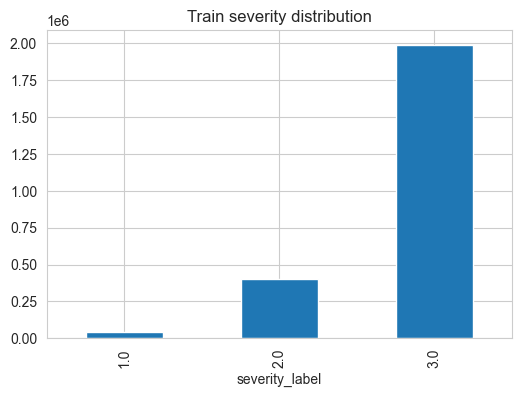

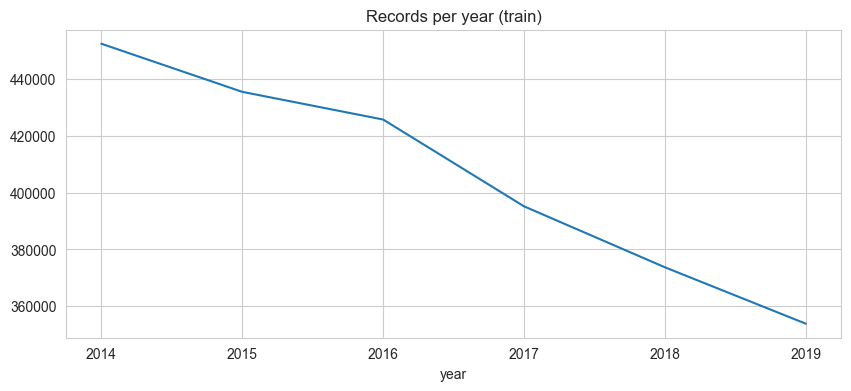

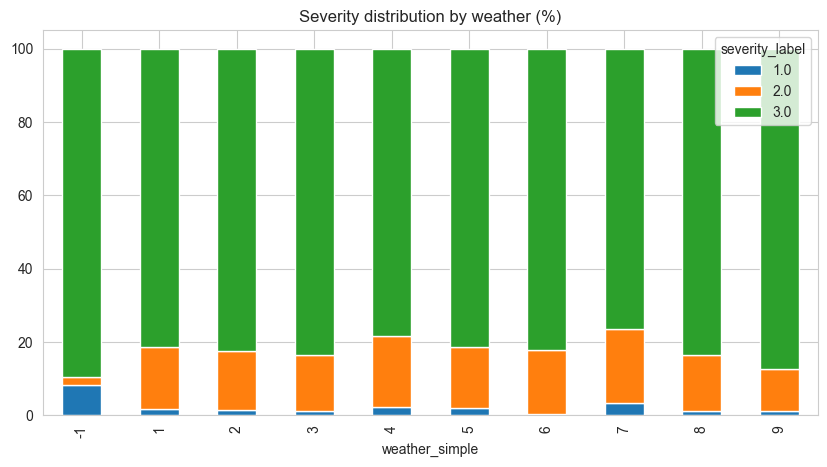

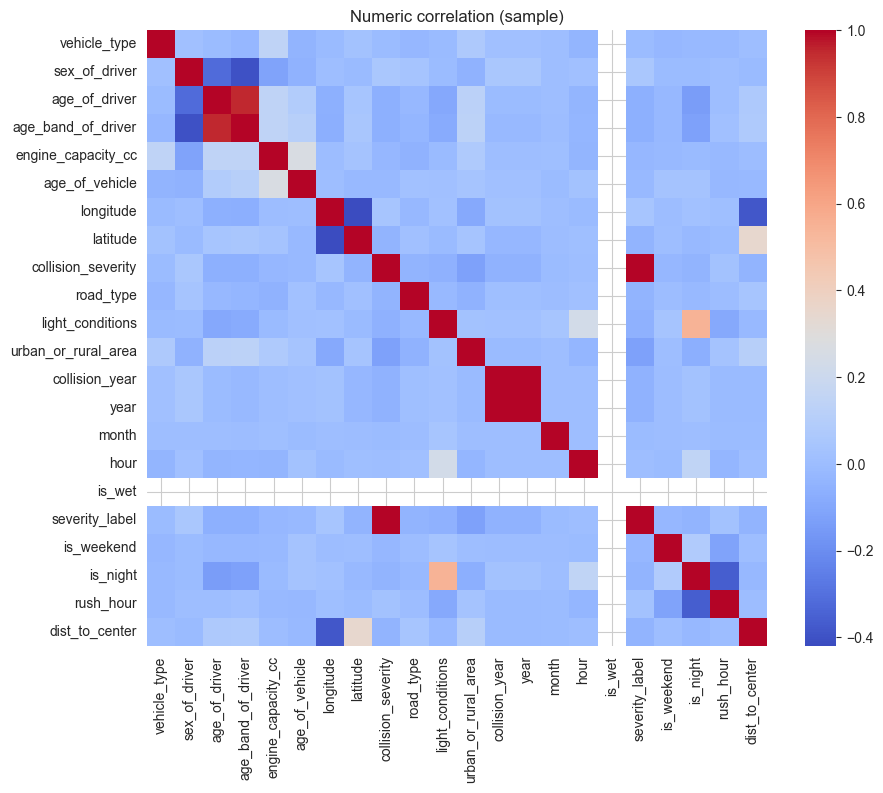

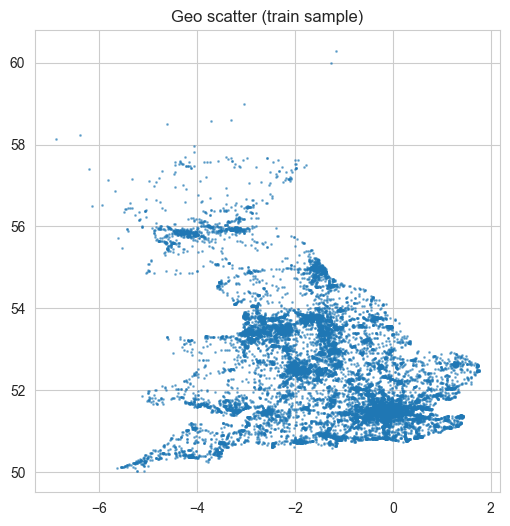

In [ ]:
def show_fig(fig):
    plt.show()
    plt.close(fig)

# Severity distribution
fig, ax = plt.subplots(figsize=(6,4))
train_fe['severity_label'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Train severity distribution')
show_fig(fig)

# Records per year
if 'year' in train_fe.columns:
    fig, ax = plt.subplots(figsize=(10,4))
    train_fe['year'].value_counts().sort_index().plot(ax=ax)
    ax.set_title('Records per year (train)')
    show_fig(fig)

# Weather vs severity percent
if 'weather_simple' in train_fe.columns:
    ct = pd.crosstab(train_fe['weather_simple'], train_fe['severity_label'], normalize='index') * 100
    fig, ax = plt.subplots(figsize=(10,5))
    ct.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('Severity distribution by weather (%)')
    show_fig(fig)

# Missing fractions
miss = train_fe.isnull().mean().sort_values(ascending=False)
top_miss = miss[miss>0].head(40)
if not top_miss.empty:
    fig, ax = plt.subplots(figsize=(10, max(3,0.25*len(top_miss))))
    top_miss.plot.bar(ax=ax)
    ax.set_title('Top missing fractions (train)')
    show_fig(fig)

# Numeric correlation (sample)
nums = train_fe.select_dtypes(include=[float,int]).columns.tolist()
if len(nums) >= 2:
    sample = train_fe[nums].dropna().sample(min(50000, max(1000, len(train_fe))))
    corr = sample.corr()
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', ax=ax)
    ax.set_title('Numeric correlation (sample)')
    show_fig(fig)

# Geo scatter (sample)
if 'latitude' in train_fe.columns and 'longitude' in train_fe.columns:
    sample = train_fe.sample(min(20000, len(train_fe)))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(sample['longitude'], sample['latitude'], s=1, alpha=0.5)
    ax.set_title('Geo scatter (train sample)')
    show_fig(fig)


In [ ]:
# 4. Feature selection & preprocessor
numeric_candidates = ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit','dist_to_center']
categorical_candidates = ['weather_simple','road_surface_conditions','light_conditions','urban_or_rural_area','road_type','vehicle_type','sex_of_driver','season']

numeric_feats = [c for c in numeric_candidates if c in train_fe.columns]
categorical_feats = [c for c in categorical_candidates if c in train_fe.columns]

print('Numeric features:', numeric_feats)
print('Categorical features:', categorical_feats)

num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', num_transform, numeric_feats), ('cat', cat_transform, categorical_feats)], remainder='drop')

Numeric features: ['age_of_driver', 'age_of_vehicle', 'engine_capacity_cc', 'speed_limit', 'dist_to_center']
Categorical features: ['weather_simple', 'road_surface_conditions', 'light_conditions', 'urban_or_rural_area', 'road_type', 'vehicle_type', 'sex_of_driver', 'season']


In [ ]:

# 5. Prepare modeling matrices
train_model = train_fe[train_fe['severity_label'].notna()].copy()
test_model   = test_fe[test_fe['severity_label'].notna()].copy()
train_model['severity_label'] = train_model['severity_label'].astype(int)
test_model['severity_label'] = test_model['severity_label'].astype(int)

train_model['severity_label'] = train_model['severity_label'] - 1
test_model['severity_label'] = test_model['severity_label'] - 1

X_train = train_model[numeric_feats + categorical_feats].copy()
y_train = train_model['severity_label'].copy()
X_test = test_model[numeric_feats + categorical_feats].copy()
y_test = test_model['severity_label'].copy()

preprocessor.fit(X_train)
X_train_p = preprocessor.transform(X_train)
X_test_p  = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_.get('cat')
ohe_cols = list(ohe.named_steps['ohe'].get_feature_names_out(categorical_feats)) if ohe is not None else []
feature_names = numeric_feats + ohe_cols

import pandas as pd
X_train_df = pd.DataFrame(X_train_p, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_p, columns=feature_names)
print('Processed shape:', X_train_df.shape)


Processed shape: (2436197, 68)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from pathlib import Path
import joblib, json, os, time

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.inspection import PartialDependenceDisplay

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier


try:
    import shap
except:
    shap = None

try:
    from sklearn.cluster import DBSCAN
except:
    DBSCAN = None

try:
    from prophet import Prophet
except:
    Prophet = None
from scipy.stats import loguniform, randint, uniform




RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
OUTDIR = Path("tuning_artifacts")
OUTDIR.mkdir(exist_ok=True)
n_iter_per_model = 40
cv_splits = 3
scoring = "f1_weighted"
n_jobs = -1
sample_frac = 0.30
if 'safe_feature_engineer' not in globals():
    print("Warning: safe_feature_engineer function not found. Defining locally.")
    def safe_feature_engineer(df):
        df = df.copy()
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day_of_week'] = df['date'].dt.day_name()
        elif 'collision_year' in df.columns:
            df['year'] = pd.to_numeric(df['collision_year'], errors='coerce')
        else:
            df['year'] = pd.NA

        if 'time' in df.columns:
            df['time'] = df['time'].astype(str).str.zfill(5).str.slice(0,5)
            df['hour'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.hour
        else:
            df['hour'] = pd.NA

        df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday']).astype(int) if 'day_of_week' in df.columns else 0
        df['is_night'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (x>=20 or x<=5) else 0) if 'hour' in df.columns else 0
        df['rush_hour'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (7<=x<=9 or 16<=x<=18) else 0) if 'hour' in df.columns else 0

        if 'month' in df.columns:
            df['season'] = df['month'].map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn'})

        if 'weather_conditions' in df.columns:
            df['weather_conditions'] = df['weather_conditions'].astype(str).fillna('')
            df['weather_simple'] = df['weather_conditions'].str.lower().apply(
                lambda s: 'rain' if 'rain' in s else ('snow' if 'snow' in s else ('fog' if 'fog' in s or 'mist' in s else ('clear' if 'clear' in s or 'fine' in s else s)))
            )
        if 'road_surface_conditions' in df.columns:
            df['road_surface_conditions'] = df['road_surface_conditions'].astype(str).fillna('')
            df['is_wet'] = df['road_surface_conditions'].str.contains('wet', case=False, na=False).astype(int)

        for c in ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit']:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce').fillna(-1)

        if 'severity_label' not in df.columns and 'collision_severity' in df.columns:
            temp_severity = df['collision_severity'].astype(str).str.strip().str.lower()
            mapping = {'slight':0, 'serious':1, 'fatal':2, '1':0, '2':1, '3':2}
            df['severity_label'] = temp_severity.map(mapping)
            df['severity_label'] = df['severity_label'].fillna(-1).astype(int)

        if 'latitude' in df.columns and 'longitude' in df.columns:
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            df = df[df['latitude'].between(-90,90) & df['longitude'].between(-180,180)]
            lat0 = df['latitude'].mean()
            lon0 = df['longitude'].mean()
            df['dist_to_center'] = ((df['latitude']-lat0)**2 + (df['longitude']-lon0)**2)**0.5
        else:
            df['dist_to_center'] = -1
        return df
else:
    safe_feature_engineer = globals()['safe_feature_engineer']

# 0. Ensure base dataframes are loaded if not present
if 'train' not in globals():
    if 'TRAIN_PQ' not in globals():
        raise RuntimeError("TRAIN_PQ path not found. Please ensure setup cell is run.")
    print("Warning: 'train' DataFrame not found. Loading from TRAIN_PQ.")
    globals()['train'] = pd.read_parquet(globals()['TRAIN_PQ'])

# 1. Ensure train_fe (feature engineered) is available
if 'train_fe' not in globals():
    print("Warning: 'train_fe' DataFrame not found. Performing feature engineering on 'train'.")
    globals()['train_fe'] = safe_feature_engineer(globals()['train'])

# 2. Re-define feature lists (numeric_feats, categorical_feats) from scratch for robustness
print("Re-defining numeric and categorical features.")
numeric_candidates = ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit','dist_to_center']
categorical_candidates = ['weather_simple','road_surface_conditions','light_conditions','urban_or_rural_area','road_type','vehicle_type','sex_of_driver','season']

numeric_feats = [c for c in numeric_candidates if c in globals()['train_fe'].columns]
categorical_feats = [c for c in categorical_candidates if c in globals()['train_fe'].columns]
globals()['numeric_feats'] = numeric_feats
globals()['categorical_feats'] = categorical_feats
print(f"Numeric features: {numeric_feats}")
print(f"Categorical features: {categorical_feats}")

# 3. Re-create preprocessor for robustness
print("Re-creating and fitting preprocessor.")
num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', num_transform, numeric_feats), ('cat', cat_transform, categorical_feats)], remainder='drop')
# Fit preprocessor on X_train-like data derived from train_fe
train_model_temp = globals()['train_fe'][globals()['train_fe']['severity_label'].notna()].copy()
X_train_temp = train_model_temp[numeric_feats + categorical_feats].copy()
preprocessor.fit(X_train_temp)
globals()['preprocessor'] = preprocessor # Make it global

# 4. Always re-create X_train and y_train for robustness
print("Re-creating X_train and y_train from train_fe for robust tuning.")
train_model = globals()['train_fe'][globals()['train_fe']['severity_label'].notna()].copy()
train_model['severity_label'] = train_model['severity_label'].astype(int)
train_model['severity_label'] = train_model['severity_label'] - 1

X_train_actual = train_model[numeric_feats + categorical_feats].copy()
y_train_actual = train_model['severity_label'].copy()
globals()['X_train'] = X_train_actual # Ensure global X_train is updated
globals()['y_train'] = y_train_actual # Ensure global y_train is updated

# Set X_train_raw and y_train for the tuner from the actual X_train and y_train
X_train_raw = X_train_actual
y_train = y_train_actual

if X_train_raw is None or y_train is None or X_train_raw.empty or y_train.empty:
    raise RuntimeError("Critical error: X_train or y_train is None or empty after direct re-creation. Data inconsistency detected.")

# Sample for tuning
if 0 < sample_frac < 1.0:
    sample_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_train_raw), size=int(len(X_train_raw)*sample_frac), replace=False)
    X_sample = X_train_raw.iloc[sample_idx]
    y_sample = y_train.iloc[sample_idx]
else:
    X_sample = X_train_raw
    y_sample = y_train

print(f"Tuning on sample rows: {len(X_sample)} (frac={sample_frac})")

cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)

tuner_results = {}

# ---------- Logistic ----------
print("\nTuning LogisticRegression ...")
pipe_lr = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])
dist_lr = {
    'clf__C': loguniform(1e-4, 1e2),
    'clf__class_weight': [None, 'balanced']
}
rs_lr = RandomizedSearchCV(pipe_lr, param_distributions=dist_lr, n_iter=min(n_iter_per_model,20),
                           scoring=scoring, cv=cv, random_state=RANDOM_STATE, n_jobs=n_jobs, verbose=1)
t0=time.time(); rs_lr.fit(X_sample, y_sample); t1=time.time()
print("Logistic best:", rs_lr.best_score_, rs_lr.best_params_, " time:", round(t1-t0,1))
joblib.dump(rs_lr, OUTDIR / "rs_logistic.joblib")
tuner_results['logistic'] = {'best_score': float(rs_lr.best_score_), 'best_params': rs_lr.best_params_}

# ---------- Random Forest ----------
print("\nTuning RandomForestClassifier ...")
pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1))])
dist_rf = {
    'clf__n_estimators': randint(100, 600),
    'clf__max_depth': randint(4, 30),
    'clf__min_samples_split': randint(2, 10),
    'clf__min_samples_leaf': randint(1, 8),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__class_weight': [None, 'balanced']
}
rs_rf = RandomizedSearchCV(pipe_rf, param_distributions=dist_rf, n_iter=n_iter_per_model,
                           scoring=scoring, cv=cv, random_state=RANDOM_STATE, n_jobs=n_jobs, verbose=1)
t0=time.time(); rs_rf.fit(X_sample, y_sample); t1=time.time()
print("RF best:", rs_rf.best_score_, rs_rf.best_params_, " time:", round(t1-t0,1))
joblib.dump(rs_rf, OUTDIR / "rs_random_forest.joblib")
tuner_results['random_forest'] = {'best_score': float(rs_rf.best_score_), 'best_params': rs_rf.best_params_}

# ---------- XGBoost ----------
print("\nTuning XGBClassifier ...")
pipe_xgb = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=1))])
dist_xgb = {
    'clf__n_estimators': randint(100, 800),
    'clf__learning_rate': loguniform(1e-3, 0.5),
    'clf__max_depth': randint(3, 10),
    'clf__subsample': uniform(0.5, 0.5),
    'clf__colsample_bytree': uniform(0.4, 0.6),
    'clf__gamma': uniform(0, 5),
    'clf__reg_alpha': loguniform(1e-6, 10),
    'clf__reg_lambda': loguniform(1e-6, 10)
}
rs_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=dist_xgb, n_iter=n_iter_per_model,
                            scoring=scoring, cv=cv, random_state=RANDOM_STATE, n_jobs=n_jobs, verbose=1)
t0=time.time(); rs_xgb.fit(X_sample, y_sample); t1=time.time()
print("XGB best:", rs_xgb.best_score_, rs_xgb.best_params_, " time:", round(t1-t0,1))
joblib.dump(rs_xgb, OUTDIR / "rs_xgboost.joblib")
tuner_results['xgboost'] = {'best_score': float(rs_xgb.best_score_), 'best_params': rs_xgb.best_params_}

# Save summary
with open(OUTDIR / "tuning_summary.json", "w", encoding="utf-8") as f:
    json.dump(tuner_results, f, indent=2)
print("\nTuning complete. Artifacts saved to:", OUTDIR)


Re-defining numeric and categorical features.
Numeric features: ['age_of_driver', 'age_of_vehicle', 'engine_capacity_cc', 'speed_limit', 'dist_to_center']
Categorical features: ['weather_simple', 'road_surface_conditions', 'light_conditions', 'urban_or_rural_area', 'road_type', 'vehicle_type', 'sex_of_driver', 'season']
Re-creating and fitting preprocessor.
Re-creating X_train and y_train from train_fe for robust tuning.
Tuning on sample rows: 730859 (frac=0.3)

Tuning LogisticRegression ...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Logistic best: 0.7421903652488343 {'clf__C': np.float64(0.39079671568228835), 'clf__class_weight': None}  time: 261.7

Tuning RandomForestClassifier ...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
RF best: 0.8026752523208377 {'clf__class_weight': 'balanced', 'clf__max_depth': 22, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 9, 'clf__n_estimators': 230}  time: 24289.8

Tuning XGBClassif

In [ ]:
import joblib, json
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline # Added

OUTDIR = Path("tuning_artifacts")
results = {}

if 'safe_feature_engineer' not in globals():
    print("Warning: safe_feature_engineer function not found. Defining locally for robustness.")
    def safe_feature_engineer(df):
        df = df.copy()
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day_of_week'] = df['date'].dt.day_name()
        elif 'collision_year' in df.columns:
            df['year'] = pd.to_numeric(df['collision_year'], errors='coerce')
        else:
            df['year'] = pd.NA

        if 'time' in df.columns:
            df['time'] = df['time'].astype(str).str.zfill(5).str.slice(0,5)
            df['hour'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.hour
        else:
            df['hour'] = pd.NA

        df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday']).astype(int) if 'day_of_week' in df.columns else 0
        df['is_night'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (x>=20 or x<=5) else 0) if 'hour' in df.columns else 0
        df['rush_hour'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (7<=x<=9 or 16<=x<=18) else 0) if 'hour' in df.columns else 0

        if 'month' in df.columns:
            df['season'] = df['month'].map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn'})

        if 'weather_conditions' in df.columns:
            df['weather_conditions'] = df['weather_conditions'].astype(str).fillna('')
            df['weather_simple'] = df['weather_conditions'].str.lower().apply(
                lambda s: 'rain' if 'rain' in s else ('snow' if 'snow' in s else ('fog' if 'fog' in s or 'mist' in s else ('clear' if 'clear' in s or 'fine' in s else s)))
            )
        if 'road_surface_conditions' in df.columns:
            df['road_surface_conditions'] = df['road_surface_conditions'].astype(str).fillna('')
            df['is_wet'] = df['road_surface_conditions'].str.contains('wet', case=False, na=False).astype(int)

        for c in ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit']:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce').fillna(-1)

        if 'severity_label' not in df.columns and 'collision_severity' in df.columns:
            temp_severity = df['collision_severity'].astype(str).str.strip().str.lower()
            mapping = {'slight':0, 'serious':1, 'fatal':2, '1':0, '2':1, '3':2}
            df['severity_label'] = temp_severity.map(mapping)
            df['severity_label'] = df['severity_label'].fillna(-1).astype(int)

        if 'latitude' in df.columns and 'longitude' in df.columns:
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            df = df[df['latitude'].between(-90,90) & df['longitude'].between(-180,180)]
            lat0 = df['latitude'].mean()
            lon0 = df['longitude'].mean()
            df['dist_to_center'] = ((df['latitude']-lat0)**2 + (df['longitude']-lon0)**2)**0.5
        else:
            df['dist_to_center'] = -1
        return df
else:
    safe_feature_engineer = globals()['safe_feature_engineer']


# Ensure TRAIN_PQ and TEST_PQ paths are available (from setup cell)
if 'TRAIN_PQ' not in globals() or 'TEST_PQ' not in globals():
    raise RuntimeError("TRAIN_PQ or TEST_PQ paths not found. Please ensure the setup cell (0. Setup) is run.")

# Ensure 'test' DataFrame is loaded if not present
if 'test' not in globals():
    print("Warning: 'test' DataFrame not found. Loading from TEST_PQ.")
    globals()['test'] = pd.read_parquet(globals()['TEST_PQ'])

# Ensure test_fe (feature engineered) is available
if 'test_fe' not in globals():
    print("Warning: 'test_fe' DataFrame not found. Performing feature engineering on 'test'.")
    globals()['test_fe'] = safe_feature_engineer(globals()['test'])

# Ensure 'train_fe' is available
if 'train' not in globals():
    print("Warning: 'train' DataFrame not found. Loading from TRAIN_PQ.")
    globals()['train'] = pd.read_parquet(globals()['TRAIN_PQ'])
if 'train_fe' not in globals():
    print("Warning: 'train_fe' DataFrame not found. Performing feature engineering on 'train'.")
    globals()['train_fe'] = safe_feature_engineer(globals()['train'])

# Re-define feature lists (numeric_feats, categorical_feats) for robustness
if 'numeric_feats' not in globals() or 'categorical_feats' not in globals():
    print("Re-defining numeric and categorical features for test set evaluation.")
    numeric_candidates = ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit','dist_to_center']
    categorical_candidates = ['weather_simple','road_surface_conditions','light_conditions','urban_or_rural_area','road_type','vehicle_type','sex_of_driver','season']

    # Always use train_fe for consistent feature list determination
    ref_df_for_feats = globals()['train_fe']

    numeric_feats = [c for c in numeric_candidates if c in ref_df_for_feats.columns]
    categorical_feats = [c for c in categorical_candidates if c in ref_df_for_feats.columns]
    globals()['numeric_feats'] = numeric_feats # Make them global for consistency
    globals()['categorical_feats'] = categorical_feats # Make them global
else:
    numeric_feats = globals()['numeric_feats']
    categorical_feats = globals()['categorical_feats']


# Re-create preprocessor if not found or if feature lists just changed (to ensure consistency)
# Preprocessor must be fitted on TRAIN data.
if 'preprocessor' not in globals():
    print("Warning: preprocessor not found. Attempting to re-create and fit using train data.")

    # Re-creating X_train and y_train here similar to tuner cell's robustness for preprocessor fitting
    train_model_temp = globals()['train_fe'][globals()['train_fe']['severity_label'].notna()].copy()
    X_train_temp_preproc_fit = train_model_temp[numeric_feats + categorical_feats].copy()

    num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
    preprocessor = ColumnTransformer([('num', num_transform, numeric_feats), ('cat', cat_transform, categorical_feats)], remainder='drop')
    preprocessor.fit(X_train_temp_preproc_fit) # Fit on (temporary) X_train data
    globals()['preprocessor'] = preprocessor # Make it global
else:
    preprocessor = globals()['preprocessor']

# Now explicitly create X_test_raw and y_test from test_fe using the determined feature lists
print("Creating X_test_raw and y_test from test_fe.")
test_model = globals()['test_fe'][globals()['test_fe']['severity_label'].notna()].copy()
test_model['severity_label'] = test_model['severity_label'].astype(int)
test_model['severity_label'] = test_model['severity_label'] - 1 # Ensure 0-indexed labels for models

X_test_raw = test_model[numeric_feats + categorical_feats].copy()
y_test = test_model['severity_label'].copy()

# --- End Defensive Code Block for Test Data ---

# Load RandomizedSearchCV objects (if present) and extract best pipelines
models_to_check = {}
for name in ['rs_logistic','rs_random_forest','rs_xgboost']:
    p = OUTDIR / f"{name}.joblib"
    if p.exists():
        rs = joblib.load(p)
        models_to_check[name.replace('rs_','')] = rs.best_estimator_
        # save the best pipeline separately
        joblib.dump(rs.best_estimator_, OUTDIR / f"{name.replace('rs_','')}_best.joblib")

# If tuned objects not present, fallback to previously-trained pipelines in notebook variables
if not models_to_check:
    print("No tuned artifacts found. Looking for existing pipeline variables in notebook (lr_pipe, rf_pipe, xgb_pipe)...")
    for cand in ['lr_pipe','rf_pipe','xgb_pipe','lr_pipeline','rf_pipeline','xgb_pipeline']:
        if cand in globals():
            models_to_check[cand] = globals()[cand]

# Evaluate each model on test set
for name, pipe in models_to_check.items():
    try:
        y_pred = pipe.predict(X_test_raw)
        acc = accuracy_score(y_test, y_pred)
        f1w = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        cr = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        cm = confusion_matrix(y_test, y_pred).tolist()
        results[name] = {'accuracy': acc, 'f1_weighted': f1w, 'classification_report': cr, 'confusion_matrix': cm}
        print(f"Model: {name} — acc={acc:.4f}, f1w={f1w:.4f}")
    except Exception as e:
        print("Evaluation failed for", name, e)

# Save model_results.json
with open(OUTDIR / "model_results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, default=str)
print("Saved model_results.json with keys:", list(results.keys()))


Creating X_test_raw and y_test from test_fe.
Model: logistic — acc=0.7557, f1w=0.6571
Model: random_forest — acc=0.6924, f1w=0.6753
Model: xgboost — acc=0.7455, f1w=0.6684
Saved model_results.json with keys: ['logistic', 'random_forest', 'xgboost']


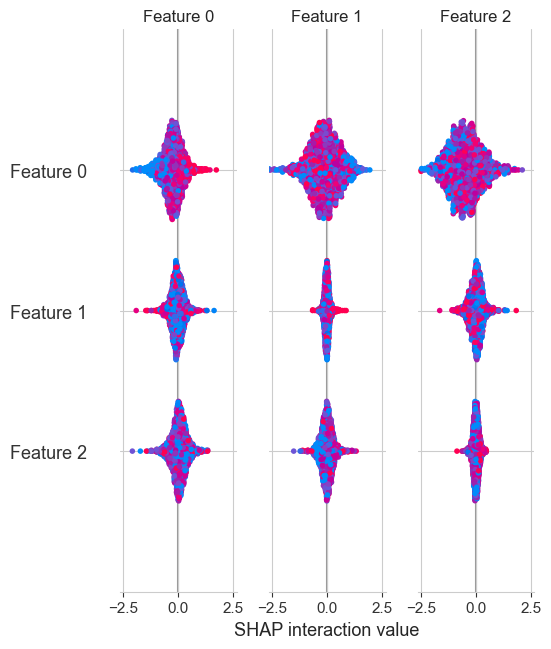

Saved SHAP summary to: tuning_artifacts\xgb_shap_summary.png


In [ ]:


import os, joblib, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
OUTDIR = Path("tuning_artifacts")
shap_out = OUTDIR / "xgb_shap_summary.png"

# locate best xgboost pipeline
xgb_best = None
for cand in [OUTDIR / "xgboost_best.joblib", OUTDIR / "rs_xgboost.joblib"]:
    if cand.exists():
        try:
            obj = joblib.load(cand)
            # if it's RandomizedSearchCV, get best_estimator_
            if hasattr(obj, 'best_estimator_'):
                xgb_best = obj.best_estimator_
            else:
                xgb_best = obj
            break
        except Exception:
            continue

# fallback: check models_to_check or globals
if xgb_best is None:
    if 'xgboost' in globals():
        xgb_best = globals()['xgboost']
    if 'xgb_pipe' in globals():
        xgb_best = globals()['xgb_pipe']

if xgb_best is None:
    print("No XGBoost model found for SHAP. Ensure tuned model exists.")
else:
    try:
        import shap
        # prepare data for SHAP
        # if pipeline: try to get preprocessor and feature names
        if hasattr(xgb_best, 'named_steps') and 'pre' in xgb_best.named_steps:
            pre = xgb_best.named_steps['pre']
            clf = xgb_best.named_steps['clf']
            # choose a sample of X_test_raw
            if 'X_test_raw' in globals():
                Xs = X_test_raw.sample(min(2000, len(X_test_raw)), random_state=42)
                X_proc = pre.transform(Xs)
                # feature names
                try:
                    # numeric + ohe names if transformer has onehot
                    ohe = pre.named_transformers_.get('cat', None)
                    if ohe is not None and hasattr(ohe, 'named_steps'):
                        ohe_step = ohe.named_steps.get('onehot', None)
                        if ohe_step is not None:
                            ohe_cols = list(ohe_step.get_feature_names_out())
                        else:
                            ohe_cols = []
                    else:
                        ohe_cols = []
                    num_cols = pre.named_transformers_.get('num', None)
                    num_cols_names = num_cols.transformers[0][2] if False else []
                except Exception:
                    ohe_cols = []
                # run SHAP
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(X_proc)
                shap.summary_plot(shap_values, X_proc, show=False)
                plt.tight_layout()
                plt.savefig(shap_out, dpi=150, bbox_inches='tight')
                plt.show()
                print("Saved SHAP summary to:", shap_out)
            else:
                print("X_test_raw not found — cannot create SHAP sample.")
        else:
            # estimator-only
            clf = xgb_best.named_steps['clf'] if hasattr(xgb_best, 'named_steps') and 'clf' in xgb_best.named_steps else xgb_best
            if 'X_test_raw' in globals():
                # try numeric features only
                Xs = X_test_raw.select_dtypes(include=[np.number]).dropna().sample(min(2000, len(X_test_raw)), random_state=42)
                explainer = shap.TreeExplainer(clf)
                shap_values = explainer.shap_values(Xs)
                shap.summary_plot(shap_values, Xs, show=False)
                plt.tight_layout()
                plt.savefig(shap_out, dpi=150, bbox_inches='tight')
                plt.show()
                print("Saved SHAP summary to:", shap_out)
            else:
                print("X_test_raw not found — cannot create SHAP sample.")
    except Exception as e:
        print("SHAP failed:", e)


In [ ]:


import joblib, json, os
OUTDIR = Path("tuning_artifacts")
lr_best_p = OUTDIR / "logistic_best.joblib"
rf_best_p = OUTDIR / "random_forest_best.joblib"
xgb_best_p = OUTDIR / "xgboost_best.joblib"

if lr_best_p.exists():
    lr_pipe = joblib.load(lr_best_p); print("Loaded lr_pipe from", lr_best_p)
if rf_best_p.exists():
    rf_pipe = joblib.load(rf_best_p); print("Loaded rf_pipe from", rf_best_p)
if xgb_best_p.exists():
    xgb_pipe = joblib.load(xgb_best_p); print("Loaded xgb_pipe from", xgb_best_p)

print("Tuned artifacts are in:", OUTDIR)
print("Now re-run your downstream evaluation/plots cells — they will use lr_pipe / rf_pipe / xgb_pipe if referenced.")


Loaded lr_pipe from tuning_artifacts\logistic_best.joblib
Loaded rf_pipe from tuning_artifacts\random_forest_best.joblib
Loaded xgb_pipe from tuning_artifacts\xgboost_best.joblib
Tuned artifacts are in: tuning_artifacts
Now re-run your downstream evaluation/plots cells — they will use lr_pipe / rf_pipe / xgb_pipe if referenced.



## 4. Modeling — train multiple models and show evaluation inline


In [ ]:

def eval_and_show(pipe, X_test_in, y_test_in, name):
    preds = pipe.predict(X_test_in)
    print(f"--- {name} ---")
    print(classification_report(y_test_in, preds, zero_division=0))
    acc = accuracy_score(y_test_in, preds)
    f1 = f1_score(y_test_in, preds, average='weighted', zero_division=0)
    print(f"Accuracy: {acc:.4f}  F1-weighted: {f1:.4f}")
    cm = confusion_matrix(y_test_in, preds)
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{name} confusion matrix")
    plt.show()
    plt.close(fig)
    if SAVE_ARTIFACTS:
        joblib.dump(pipe, ARTIFACTS / f"{name}.joblib")
    return {'accuracy': float(acc), 'f1_weighted': float(f1)}

results = {}











--- logistic ---
              precision    recall  f1-score   support

           0       0.05      0.63      0.10     28726
           1       0.28      0.22      0.25    330230
           2       0.81      0.63      0.71   1098117

    accuracy                           0.53   1457073
   macro avg       0.38      0.49      0.35   1457073
weighted avg       0.68      0.53      0.59   1457073

Accuracy: 0.5341  F1-weighted: 0.5913


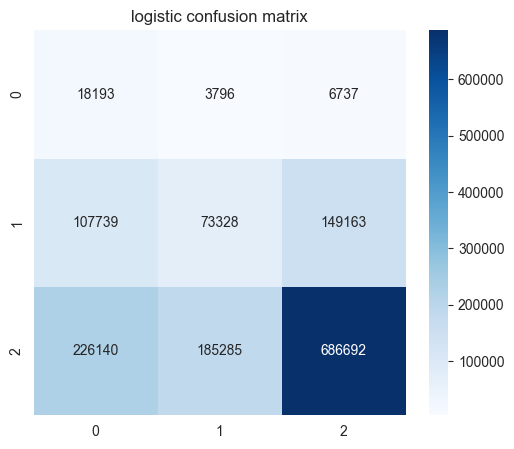

In [ ]:
# Logistic
lr_pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))])
lr_pipe.fit(X_train, y_train)
results['logistic'] = eval_and_show(lr_pipe, X_test, y_test, 'logistic')

--- random_forest ---
              precision    recall  f1-score   support

           0       0.06      0.00      0.01     28726
           1       0.34      0.06      0.10    330230
           2       0.76      0.96      0.85   1098117

    accuracy                           0.74   1457073
   macro avg       0.39      0.34      0.32   1457073
weighted avg       0.65      0.74      0.66   1457073

Accuracy: 0.7411  F1-weighted: 0.6642


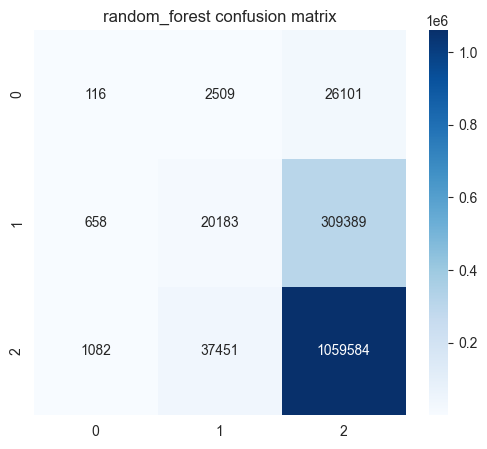

In [ ]:
rf_pipe = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=120, random_state=RANDOM_STATE, n_jobs=-1))])
rf_pipe.fit(X_train, y_train)
results['random_forest'] = eval_and_show(rf_pipe, X_test, y_test, 'random_forest')

--- xgboost ---
              precision    recall  f1-score   support

           0       0.33      0.00      0.00     28726
           1       0.57      0.02      0.05    330230
           2       0.76      1.00      0.86   1098117

    accuracy                           0.76   1457073
   macro avg       0.55      0.34      0.30   1457073
weighted avg       0.71      0.76      0.66   1457073

Accuracy: 0.7560  F1-weighted: 0.6592


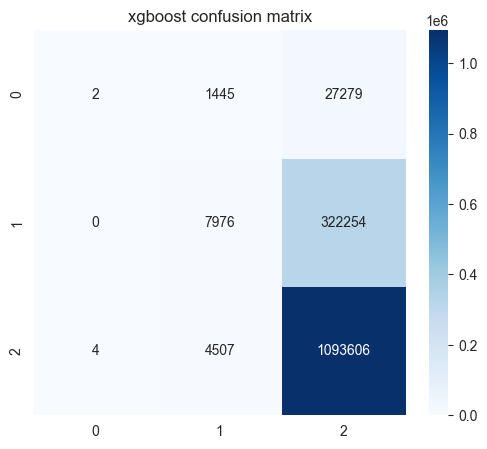

In [ ]:
# XGBoost
xgb_pipe = Pipeline([('pre', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1))])
xgb_pipe.set_params(**{'clf__n_estimators':200,'clf__learning_rate':0.05,'clf__max_depth':6})
xgb_pipe.fit(X_train, y_train)
results['xgboost'] = eval_and_show(xgb_pipe, X_test, y_test, 'xgboost')

  File "C:\Users\saikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\saikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __ini

--- smote_rf ---
              precision    recall  f1-score   support

           0       0.07      0.01      0.02     28726
           1       0.33      0.08      0.13    330230
           2       0.76      0.95      0.85   1098117

    accuracy                           0.74   1457073
   macro avg       0.39      0.35      0.33   1457073
weighted avg       0.65      0.74      0.67   1457073

Accuracy: 0.7355  F1-weighted: 0.6664


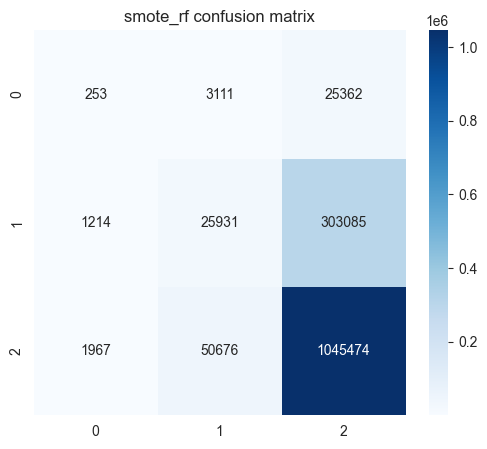

In [ ]:
y_train_counts = y_train.value_counts()
smote_sampling_strategy_dict = {
    0: min(100000, int(y_train_counts.get(2, 0) * 0.1)), # Cap class 0 to 100k or 10% of majority
    1: min(600000, int(y_train_counts.get(2, 0) * 0.3))  # Cap class 1 to 600k or 30% of majority
}
smote_pipe = ImbPipeline([('pre', preprocessor), ('sm', SMOTE(sampling_strategy=smote_sampling_strategy_dict, random_state=RANDOM_STATE)), ('clf', RandomForestClassifier(n_estimators=80, random_state=RANDOM_STATE, n_jobs=-1))])
smote_pipe.fit(X_train, y_train)
results['smote_rf'] = eval_and_show(smote_pipe, X_test, y_test, 'smote_rf')

--- stacking ---
              precision    recall  f1-score   support

           0       0.09      0.01      0.02     28726
           1       0.34      0.08      0.13    330230
           2       0.76      0.95      0.85   1098117

    accuracy                           0.74   1457073
   macro avg       0.40      0.35      0.33   1457073
weighted avg       0.65      0.74      0.67   1457073

Accuracy: 0.7365  F1-weighted: 0.6686


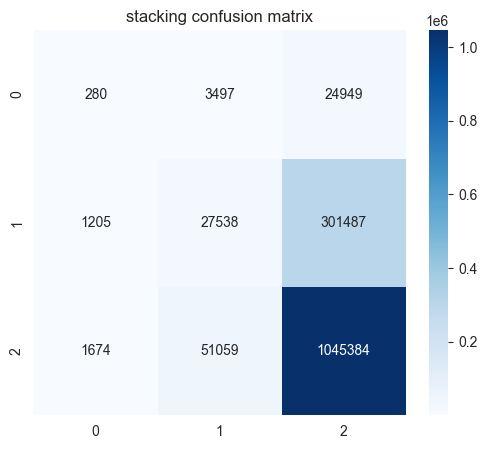

In [ ]:
rf_est = rf_pipe.named_steps['clf']
xgb_est = xgb_pipe.named_steps['clf']
stack_est = StackingClassifier(estimators=[('rf', rf_est), ('xgb', xgb_est)], final_estimator=LogisticRegression(), n_jobs=1)
stack_pipe = Pipeline([('pre', preprocessor), ('clf', stack_est)])
stack_pipe.fit(X_train, y_train)
results['stacking'] = eval_and_show(stack_pipe, X_test, y_test, 'stacking')

In [ ]:
# Results table
import pandas as pd
res_df = pd.DataFrame(results).T
display(res_df)
if SAVE_ARTIFACTS:
    with open(ARTIFACTS / 'model_results.json','w', encoding='utf-8') as f:
        json.dump(results, f, indent=2)

,accuracy,f1_weighted
logistic,0.534093,0.591302
random_forest,0.741132,0.664170
xgboost,0.756025,0.659157
smote_rf,0.735487,0.666446
stacking,0.736546,0.668570



## 5. SHAP explainability (XGBoost)


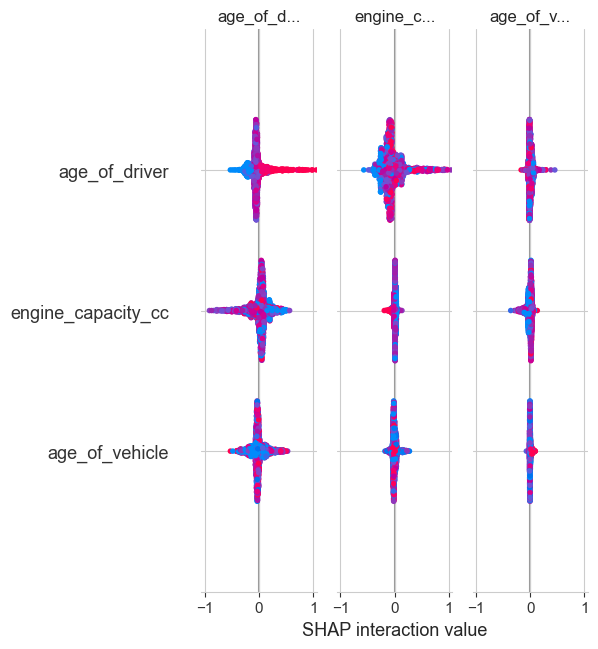

In [ ]:

try:
    model_xgb = xgb_pipe.named_steps['clf']
    X_test_proc_df = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names)
    sample = X_test_proc_df.sample(min(2000, len(X_test_proc_df)), random_state=RANDOM_STATE)
    explainer = shap.TreeExplainer(model_xgb)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, show=False)
    plt.tight_layout()
    plt.show()
    plt.close('all')
except Exception as e:
    print('SHAP failed:', e)


In [ ]:

# Save preprocessor and feature names for reproducibility
if SAVE_ARTIFACTS:
    joblib.dump(preprocessor, ARTIFACTS / 'preprocessor.joblib')
    with open(ARTIFACTS / 'feature_names.json', 'w', encoding='utf-8') as f:
        json.dump(feature_names, f, indent=2)
    print('Saved preprocessor and feature names to', ARTIFACTS)


Saved preprocessor and feature names to \content\artifacts_inline


Artifacts folder: \content\artifacts_inline
Using codebook: \content\dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024.xlsx
Loaded codebook sheets: ['2024_code_list']
Applied mappings to train_fe columns: {}
Applied mappings to test_fe columns: {}
Rebuilt numeric_feats: ['age_of_driver', 'age_of_vehicle', 'engine_capacity_cc', 'speed_limit', 'dist_to_center']
Rebuilt categorical_feats: ['weather_simple', 'road_surface_conditions', 'light_conditions', 'urban_or_rural_area', 'road_type', 'vehicle_type', 'sex_of_driver', 'season', 'age_band_of_driver']
Preprocessor refit and saved. Processed feature count: 80
severity_label unique sample: [1.0, 2.0, 3.0]
sev_std distribution (train):
{2: 1990463, 1: 405036, 0: 40698}

--- Age-group severity model (balanced training) ---
Balanced sample counts: {0: 3207, 1: 3207}
Age-model classification report (balanced):
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       642
      

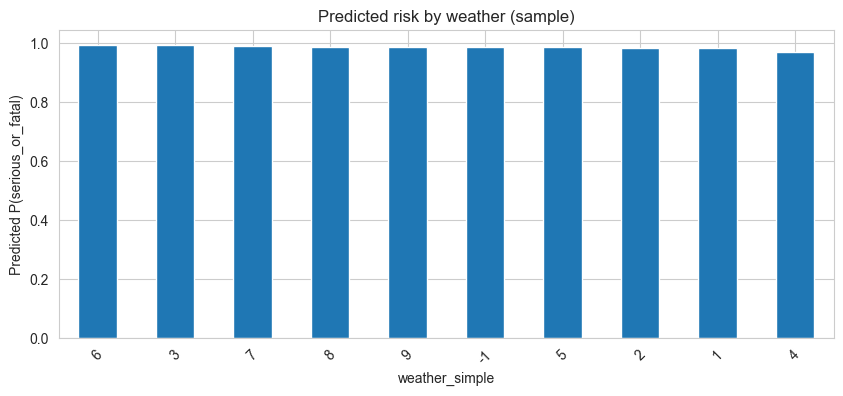


--- Interaction analysis: SHAP & PDP (safe) ---
SHAP safe call failed: columns are missing: {'age_band_of_driver'}


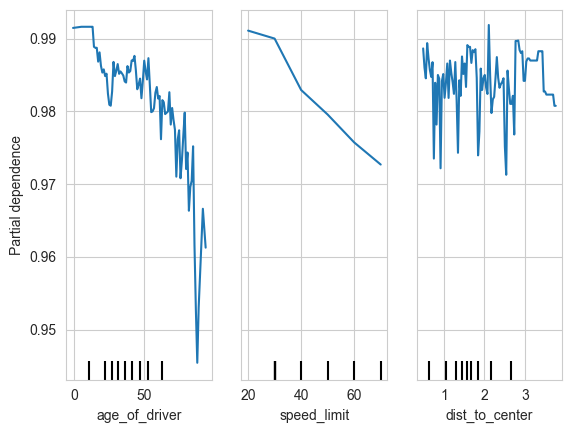


--- Auxiliary binary models: serious_or_fatal & fatal_only ---
Aux features used: ['age_of_driver', 'age_of_vehicle', 'engine_capacity_cc', 'speed_limit', 'dist_to_center', 'weather_simple', 'road_surface_conditions', 'light_conditions', 'urban_or_rural_area', 'road_type', 'vehicle_type', 'sex_of_driver', 'season', 'age_band_of_driver']
Aux serious_or_fatal report:
              precision    recall  f1-score   support

           0       0.96      0.21      0.34       641
           1       0.99      1.00      0.99     39359

    accuracy                           0.99     40000
   macro avg       0.97      0.60      0.67     40000
weighted avg       0.99      0.99      0.98     40000

Aux fatal_only report:
              precision    recall  f1-score   support

           0       0.66      0.21      0.32      7287
           1       0.85      0.98      0.91     32713

    accuracy                           0.84     40000
   macro avg       0.75      0.59      0.61     40000
weighted 

In [ ]:


import pandas as pd
import numpy as np
from pathlib import Path
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# ML imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

# Artifact folder
ARTIFACTS = Path(ARTIFACTS) if 'ARTIFACTS' in globals() else Path("./artifacts_updated")
ARTIFACTS.mkdir(parents=True, exist_ok=True)
SAVE_ARTIFACTS = globals().get('SAVE_ARTIFACTS', True)

print("Artifacts folder:", ARTIFACTS)

# --- Robustness: Ensure train, test, train_fe, test_fe, and safe_feature_engineer are available ---
if 'DATA_DIR' not in globals():
    DATA_DIR = Path("/content") # Default if not defined
if 'TRAIN_PQ' not in globals():
    TRAIN_PQ = DATA_DIR / "train.parquet"
if 'TEST_PQ' not in globals():
    TEST_PQ  = DATA_DIR / "test.parquet"

# Load raw data if not present
if 'train' not in globals():
    print("Warning: 'train' DataFrame not found. Loading from TRAIN_PQ.")
    globals()['train'] = pd.read_parquet(TRAIN_PQ)
if 'test' not in globals():
    print("Warning: 'test' DataFrame not found. Loading from TEST_PQ.")
    globals()['test'] = pd.read_parquet(TEST_PQ)

# Re-define safe_feature_engineer locally if it's not in globals
if 'safe_feature_engineer' not in globals():
    print("Warning: safe_feature_engineer function not found. Defining locally.")
    def safe_feature_engineer(df):
        df = df.copy()
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day_of_week'] = df['date'].dt.day_name()
        elif 'collision_year' in df.columns:
            df['year'] = pd.to_numeric(df['collision_year'], errors='coerce')
        else:
            df['year'] = pd.NA

        if 'time' in df.columns:
            df['time'] = df['time'].astype(str).str.zfill(5).str.slice(0,5)
            df['hour'] = pd.to_datetime(df['time'], format='%H:%M', errors='coerce').dt.hour
        else:
            df['hour'] = pd.NA

        df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday']).astype(int) if 'day_of_week' in df.columns else 0
        df['is_night'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (x>=20 or x<=5) else 0) if 'hour' in df.columns else 0
        df['rush_hour'] = df['hour'].apply(lambda x: 1 if pd.notna(x) and (7<=x<=9 or 16<=x<=18) else 0) if 'hour' in df.columns else 0

        if 'month' in df.columns:
            df['season'] = df['month'].map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn'})

        if 'weather_conditions' in df.columns:
            df['weather_conditions'] = df['weather_conditions'].astype(str).fillna('')
            df['weather_simple'] = df['weather_conditions'].str.lower().apply(
                lambda s: 'rain' if 'rain' in s else ('snow' if 'snow' in s else ('fog' if 'fog' in s or 'mist' in s else ('clear' if 'clear' in s or 'fine' in s else s)))
            )
        if 'road_surface_conditions' in df.columns:
            df['road_surface_conditions'] = df['road_surface_conditions'].astype(str).fillna('')
            df['is_wet'] = df['road_surface_conditions'].str.contains('wet', case=False, na=False).astype(int)

        for c in ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit']:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce').fillna(-1)

        if 'severity_label' not in df.columns and 'collision_severity' in df.columns:
            # Convert collision_severity to string to handle both text and numeric labels consistently
            temp_severity = df['collision_severity'].astype(str).str.strip().str.lower()

            # Define a comprehensive mapping for both string descriptions and numeric codes (as strings)
            mapping = {'slight':0, 'serious':1, 'fatal':2,
                       '1':0, '2':1, '3':2} # Handle numeric '1', '2', '3' directly

            df['severity_label'] = temp_severity.map(mapping)

            # Fill any remaining NaNs (for unmapped or unparseable values) with -1 before converting to int.
            # These could be dropped later or handled differently if they represent actual missing data.
            df['severity_label'] = df['severity_label'].fillna(-1).astype(int)

        if 'latitude' in df.columns and 'longitude' in df.columns:
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            df = df[df['latitude'].between(-90,90) & df['longitude'].between(-180,180)]
            lat0 = df['latitude'].mean()
            lon0 = df['longitude'].mean()
            df['dist_to_center'] = ((df['latitude']-lat0)**2 + (df['longitude']-lon0)**2)**0.5
        else:
            df['dist_to_center'] = -1

        return df
else:
    safe_feature_engineer = globals()['safe_feature_engineer']

# Create feature engineered dataframes if not present
if 'train_fe' not in globals():
    print("Warning: 'train_fe' DataFrame not found. Performing feature engineering on 'train'.")
    globals()['train_fe'] = safe_feature_engineer(globals()['train'])
if 'test_fe' not in globals():
    print("Warning: 'test_fe' DataFrame not found. Performing feature engineering on 'test'.")
    globals()['test_fe'] = safe_feature_engineer(globals()['test'])

# -----------------------
# 0) Robust codebook loader (if not already loaded)
# -----------------------
CODEBOOK_PATHS = [
    "/content/dft_road_codebook.xlsx",
    "/content/dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024 (1).xlsx",
    "/content/dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024.xlsx",
    "dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024 (1).xlsx"
]
codebook_path = next((Path(p) for p in CODEBOOK_PATHS if Path(p).exists()), None)
if codebook_path is None:
    print("Codebook not found at known locations. If you have it, set CODEBOOK_PATH to correct path and re-run.")
    mappings = globals().get('mappings', {})
else:
    print("Using codebook:", codebook_path)
    def build_mappings_from_excel(path):
        xl = pd.ExcelFile(path)
        mappings = {}
        for sheet in xl.sheet_names:
            try:
                df = xl.parse(sheet, dtype=object)
            except Exception:
                continue
            df = df.dropna(how='all', axis=0).dropna(how='all', axis=1)
            if df.shape[1] < 2:
                continue
            cols = list(df.columns)
            # heuristics
            code_col = next((c for c in cols if 'code' in str(c).lower() or 'value'==str(c).lower() or 'id'==str(c).lower()), None)
            label_col = next((c for c in cols if 'label' in str(c).lower() or 'meaning' in str(c).lower() or 'description' in str(c).lower()), None)
            if code_col is None or label_col is None:
                code_col, label_col = cols[0], cols[1]
            mapping = {}
            for _, row in df[[code_col, label_col]].dropna().iterrows():
                k = row[code_col]
                v = row[label_col]
                try:
                    v = str(v).strip()
                except:
                    v = v
                # try integer key
                try:
                    if pd.notna(k) and str(k).strip() != '':
                        f = float(k)
                        if float(f).is_integer():
                            kk = int(f)
                        else:
                            kk = str(k).strip()
                    else:
                        continue
                except Exception:
                    kk = str(k).strip()
                mapping[kk] = v
            key_name = str(sheet).strip().lower().replace(" ", "_")
            mappings[key_name] = mapping
        return mappings

    mappings = build_mappings_from_excel(codebook_path)
    print("Loaded codebook sheets:", list(mappings.keys())[:10])
    # save summary
    with open(ARTIFACTS / "codebook_summary.json", "w", encoding="utf-8") as f:
        json.dump({k: len(v) for k,v in mappings.items()}, f, indent=2)

# -----------------------
# 1) Robust application of mappings to train_fe/test_fe
# -----------------------
def find_best_mapping_for_col(col_name, mappings):
    col = col_name.lower().replace(' ', '_')
    # exact
    if col in mappings:
        return col
    # substring
    for mk in mappings:
        if mk in col or col in mk:
            return mk
    # token overlap
    col_tokens = set(col.split('_'))
    best = None; best_score = 0
    for mk in mappings:
        mk_tokens = set(mk.split('_'))
        score = len(col_tokens & mk_tokens)
        if score > best_score:
            best, best_score = mk, score
    if best_score > 0:
        return best
    return None

def apply_mappings_to_df(df, mappings):
    df = df.copy()
    applied = {}
    for col in df.columns:
        mk = find_best_mapping_for_col(col, mappings)
        if mk is None:
            continue
        mapping = mappings.get(mk, {})
        if not mapping:
            continue
        # prepare proc_map (int and str keys)
        proc_map = {}
        for k,v in mapping.items():
            proc_map[k] = v
            proc_map[str(k)] = v
            try:
                if isinstance(k, str) and k.replace('.0','').isdigit():
                    proc_map[int(float(k))] = v
            except:
                pass
        # check overlap
        unique_vals = pd.unique(df[col].dropna())[:500]
        overlap = 0
        for u in unique_vals:
            if u in proc_map or str(u) in proc_map:
                overlap += 1
            else:
                try:
                    iu = int(float(u))
                    if iu in proc_map:
                        overlap += 1
                except:
                    pass
        if overlap == 0:
            continue
        # map values
        def mapper(v):
            if pd.isna(v):
                return v
            if v in proc_map:
                return proc_map[v]
            sv = str(v)
            if sv in proc_map:
                return proc_map[sv]
            try:
                iv = int(float(v))
                if iv in proc_map:
                    return proc_map[iv]
            except:
                pass
            return v
        df[col] = df[col].apply(mapper)
        applied[col] = mk
    return df, applied

applied_summary = {}
# Now train_fe and test_fe are guaranteed to exist globally
train_fe_mapped, applied_train = apply_mappings_to_df(train_fe, mappings)
print("Applied mappings to train_fe columns:", applied_train)
applied_summary['train'] = applied_train
train_fe = train_fe_mapped

test_fe_mapped, applied_test = apply_mappings_to_df(test_fe, mappings)
print("Applied mappings to test_fe columns:", applied_test)
applied_summary['test'] = applied_test
test_fe = test_fe_mapped

# Save applied summary
with open(ARTIFACTS / "applied_mappings_summary.json", "w", encoding="utf-8") as f:
    json.dump(applied_summary, f, indent=2)

if 'age_band_of_driver' in train_fe.columns:
    # find codebook key that looks like age
    ag_key = next((k for k in mappings if 'age' in k), None)
    if ag_key:
        age_map = mappings[ag_key]
        # coerce keys to ints where possible
        proc_age = {}
        for k,v in age_map.items():
            try:
                proc_age[int(k)] = v
            except:
                proc_age[str(k)] = v
        def map_age(v):
            try:
                if pd.isna(v):
                    return v
                iv = int(float(v))
                return proc_age.get(iv, proc_age.get(str(v), v))
            except Exception:
                return proc_age.get(v, v)
        train_fe['age_band_of_driver'] = train_fe['age_band_of_driver'].apply(map_age)
        if 'test_fe' in globals():
            test_fe['age_band_of_driver'] = test_fe['age_band_of_driver'].apply(map_age)
        print("Mapped age_band_of_driver sample:", pd.unique(train_fe['age_band_of_driver'])[:10])

# -----------------------
# 2) Rebuild preprocessor on current train_fe
# -----------------------
numeric_candidates = ['age_of_driver','age_of_vehicle','engine_capacity_cc','speed_limit','dist_to_center']
categorical_candidates = ['weather_simple','road_surface_conditions','light_conditions','urban_or_rural_area','road_type','vehicle_type','sex_of_driver','season','age_band_of_driver']

train_ref = train_fe # train_fe is now guaranteed to exist

numeric_feats = [c for c in numeric_candidates if c in train_ref.columns]
categorical_feats = [c for c in categorical_candidates if c in train_ref.columns]

print("Rebuilt numeric_feats:", numeric_feats)
print("Rebuilt categorical_feats:", categorical_feats)

num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_transform, numeric_feats),
    ('cat', cat_transform, categorical_feats)
], remainder='drop')

# Fit preprocessor
X_fit = train_ref[numeric_feats + categorical_feats].copy()
preprocessor.fit(X_fit)
# build feature_names for later use (if possible)
try:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    # Check for get_feature_names_out, fallback to get_feature_names
    if hasattr(ohe, 'get_feature_names_out'):
        ohe_cols = list(ohe.get_feature_names_out(categorical_feats))
    elif hasattr(ohe, 'get_feature_names'):
        ohe_cols = list(ohe.get_feature_names(categorical_feats))
    else:
        ohe_cols = []
        print("Warning: OneHotEncoder has neither 'get_feature_names_out' nor 'get_feature_names'. Feature names might be incomplete.")
except Exception as e:
    ohe_cols = []
    print(f"Error getting OHE feature names: {e}. Falling back to empty list.")

feature_names = numeric_feats + ohe_cols

# save preprocessor
joblib.dump(preprocessor, ARTIFACTS / "preprocessor_refit.joblib")
with open(ARTIFACTS / "feature_names.json", "w", encoding="utf-8") as f:
    json.dump(feature_names, f, indent=2)
print("Preprocessor refit and saved. Processed feature count:", len(feature_names))

# -----------------------
# 3) Helper: ensure columns present before transform
# -----------------------
def ensure_columns_for_transform(df, expected_cols, fill_value=np.nan):
    df = df.copy()
    for c in expected_cols:
        if c not in df.columns:
            if c in ['year','hour','speed_limit','age_of_driver','age_of_vehicle','engine_capacity_cc','dist_to_center']:
                df[c] = -1
            elif c.endswith('_flag') or c.startswith('is_'):
                df[c] = 0
            else:
                df[c] = "Unknown"
    return df

# -----------------------
# 4) Standardize severity label to sev_std: 0=slight,1=serious,2=fatal
# -----------------------
if 'severity_label' in train_fe.columns:
    # check common patterns (could be 1/2/3 or 0/1/2)
    vals = sorted(pd.unique(train_fe['severity_label'].dropna()).tolist())
    print("severity_label unique sample:", vals[:10])
    if set(vals).issubset({1,2,3}):
        train_fe['sev_std'] = train_fe['severity_label'].astype(int) - 1
    else:
        train_fe['sev_std'] = train_fe['severity_label'].astype(int)
else:
    raise RuntimeError("severity_label not found in train_fe")

if 'test_fe' in globals() and 'severity_label' in test_fe.columns:
    vals_t = sorted(pd.unique(test_fe['severity_label'].dropna()).tolist())
    if set(vals_t).issubset({1,2,3}):
        test_fe['sev_std'] = test_fe['severity_label'].astype(int) - 1
    else:
        test_fe['sev_std'] = test_fe['severity_label'].astype(int)

print("sev_std distribution (train):")
print(train_fe['sev_std'].value_counts(normalize=False).to_dict())

# -----------------------
# 5) Age-group severity model (balanced training)
# -----------------------
print("\n--- Age-group severity model (balanced training) ---")
age_feat_candidates = [f for f in ['age_of_driver','age_band_of_driver','speed_limit','weather_simple','light_conditions','vehicle_type'] if f in train_fe.columns]

if 'age_of_driver' in train_fe.columns or 'age_band_of_driver' in train_fe.columns:
    df_dev = train_fe.dropna(subset=['sev_std']).sample(min(200000, len(train_fe)), random_state=42)  # sample for speed
    target = 'serious_or_fatal'  # will create below
    df_dev[target] = (df_dev['sev_std'] >= 1).astype(int)
    X_df = df_dev[age_feat_candidates].copy()
    X_df_safe = ensure_columns_for_transform(X_df, numeric_feats + categorical_feats)
    # transform using preprocessor (safe)
    try:
        X_proc = preprocessor.transform(X_df_safe)
    except Exception as e:
        print("Transform failed unexpectedly:", e)
        # fallback to simple encoding
        for col in X_df_safe.select_dtypes(include=['object','category']).columns:
            X_df_safe[col] = X_df_safe[col].fillna('Unknown').astype(str)
            X_df_safe[col] = LabelEncoder().fit_transform(X_df_safe[col])
        for col in X_df_safe.select_dtypes(include=[np.number]).columns:
            X_df_safe[col] = X_df_safe[col].fillna(X_df_safe[col].median())
        X_proc = X_df_safe.values

    y = df_dev[target].astype(int).values

    # Balanced sampling (undersample majority)
    rus = RandomUnderSampler(random_state=42)
    try:
        X_bal, y_bal = rus.fit_resample(X_proc, y)
        print("Balanced sample counts:", pd.Series(y_bal).value_counts().to_dict())
    except Exception as e:
        print("Undersampler failed; proceeding without resampling:", e)
        X_bal, y_bal = X_proc, y

    # train/test split on original processed arrays (stratify by y if possible)
    X_tr, X_val, y_tr, y_val = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal if len(np.unique(y_bal))>1 else None)

    age_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=300, max_depth=4, random_state=42, n_jobs=-1)
    age_xgb.fit(X_tr, y_tr)
    y_pred = age_xgb.predict(X_val)
    print("Age-model classification report (balanced):")
    print(classification_report(y_val, y_pred, zero_division=0))
    # save
    if SAVE_ARTIFACTS:
        joblib.dump(age_xgb, ARTIFACTS / "age_xgb_balanced.joblib")
else:
    print("No age column present; skipping age-group model.")

# -----------------------
# 6) Weather-impact risk profiling
# -----------------------
print("\n--- Weather-impact risk profiling (global XGB) ---")
if 'weather_simple' in train_fe.columns:
    df_w = train_fe.dropna(subset=['sev_std']).sample(min(200000, len(train_fe)), random_state=42)
    df_w['serious_or_fatal'] = (df_w['sev_std'] >= 1).astype(int)
    features_weather = [c for c in (numeric_feats + categorical_feats) if c in df_w.columns]
    Xw_df = df_w[features_weather].copy()
    Xw_safe = ensure_columns_for_transform(Xw_df, numeric_feats + categorical_feats)
    try:
        Xw_proc = preprocessor.transform(Xw_safe)
    except Exception as e:
        print("Transform failed for weather profiling:", e)
        # fallback simple encoding
        for col in Xw_safe.select_dtypes(include=['object','category']).columns:
            Xw_safe[col] = Xw_safe[col].fillna('Unknown').astype(str)
            Xw_safe[col] = LabelEncoder().fit_transform(Xw_safe[col])
        for col in Xw_safe.select_dtypes(include=[np.number]).columns:
            Xw_safe[col] = Xw_safe[col].fillna(Xw_safe[col].median())
        Xw_proc = Xw_safe.values

    y_w = df_w['serious_or_fatal'].astype(int).values
    # quick train
    wxgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, max_depth=6, random_state=42, n_jobs=-1)
    wxgb.fit(Xw_proc, y_w)
    # evaluate on holdout slice from df_w
    X_train_w, X_val_w, y_train_w, y_val_w = train_test_split(Xw_proc, y_w, test_size=0.2, random_state=42, stratify=y_w)
    ypred_w = wxgb.predict(X_val_w)
    print("Weather global model report:")
    print(classification_report(y_val_w, ypred_w, zero_division=0))
    if SAVE_ARTIFACTS:
        joblib.dump(wxgb, ARTIFACTS / "weather_xgb_global.joblib")
    # compute predicted prob by weather category on sample of original rows (safe)
    df_sample = df_w.sample(min(10000, len(df_w)), random_state=42)
    Xs_safe = ensure_columns_for_transform(df_sample[features_weather], numeric_feats + categorical_feats)
    try:
        Xs_proc = preprocessor.transform(Xs_safe)
    except Exception:
        # fallback
        for col in Xs_safe.select_dtypes(include=['object','category']).columns:
            Xs_safe[col] = Xs_safe[col].fillna('Unknown').astype(str)
            Xs_safe[col] = LabelEncoder().fit_transform(Xs_safe[col])
        for col in Xs_safe.select_dtypes(include=[np.number]).columns:
            Xs_safe[col] = Xs_safe[col].fillna(Xs_safe[col].median())
        Xs_proc = Xs_safe.values
    probs = wxgb.predict_proba(Xs_proc)[:,1]
    df_sample = df_sample.copy()
    df_sample['pred_prob_serious'] = probs
    summary = df_sample.groupby('weather_simple')['pred_prob_serious'].agg(['mean','count']).sort_values('mean', ascending=False).reset_index()
    print(summary.head(15))
    # plot
    fig, ax = plt.subplots(figsize=(10,4))
    summary.plot(kind='bar', x='weather_simple', y='mean', legend=False, ax=ax)
    ax.set_ylabel("Predicted P(serious_or_fatal)")
    ax.set_title("Predicted risk by weather (sample)")
    plt.xticks(rotation=45)
    if SAVE_ARTIFACTS:
        fig.savefig(ARTIFACTS / "weather_pred_risk_updated.png", bbox_inches='tight', dpi=150)
    plt.show()
    plt.close(fig)
else:
    print("weather_simple not present; skipping weather profiling.")

# -----------------------
# 7) Interaction analysis: SHAP (safe) & PDP (pipeline)
# -----------------------
print("\n--- Interaction analysis: SHAP & PDP (safe) ---")
# try to use main trained model (wxgb if exists else age_xgb else any)
main_clf = None
for cand in ['wxgb','age_xgb','xgb_pipe','xgb']:
    if cand in globals() and globals()[cand] is not None:
        main_clf = globals()[cand]
        break

if main_clf is None and 'xgb_pipe' in globals():
    try:
        main_clf = xgb_pipe.named_steps['clf']
    except Exception:
        main_clf = None

if main_clf is None:
    print("No main tree model found for SHAP/PDP. Use a trained XGBoost or RandomForest classifier.")
else:
    # prepare small processed DataFrame for SHAP
    try:
        # build processed DataFrame for X_test or sample from train
        if 'X_test' in globals():
            X_proc_df = pd.DataFrame(preprocessor.transform(X_test if isinstance(X_test, pd.DataFrame) else X_test), columns=feature_names)
        else:
            sample_df_shap = train_fe.sample(min(5000, len(train_fe)), random_state=42)
            X_proc_df = pd.DataFrame(preprocessor.transform(ensure_columns_for_transform(sample_df_shap[numeric_feats+categorical_feats], numeric_feats + categorical_feats)), columns=feature_names)
        import shap
        sample_n = min(500, len(X_proc_df))
        Xs = X_proc_df.sample(sample_n, random_state=42)
        expl = shap.TreeExplainer(main_clf)
        shap_vals = expl.shap_values(Xs)
        if isinstance(shap_vals, list):
            # multiclass: choose class 1 (serious) for summary; you can change index
            cls_idx = 1 if len(shap_vals) > 1 else 0
            shap.summary_plot(shap_vals[cls_idx], Xs, show=True)
        else:
            shap.summary_plot(shap_vals, Xs, show=True)
    except Exception as e:
        print("SHAP safe call failed:", e)

    # PDP: wrap pipeline so estimator accepts raw X DataFrame
    try:
        # create pipeline with preprocessor + main_clf if main_clf expects arrays
        pipe_for_pdp = Pipeline([('pre', preprocessor), ('clf', main_clf)])
        # choose PDP features that are original column names (not processed)
        pd_features = [f for f in ['age_of_driver','speed_limit','dist_to_center'] if f in train_fe.columns]
        if pd_features:
            # sample raw X for PDP (must be DataFrame of original raw features)
            raw_X = train_fe[numeric_feats + categorical_feats].sample(min(2000, len(train_fe)), random_state=42)
            PartialDependenceDisplay.from_estimator(pipe_for_pdp, raw_X, pd_features, kind='average', subsample=500, random_state=42)
            plt.show()
    except Exception as e:
        print("PDP failed:", e)

# -----------------------
# 8) Auxiliary binary models (serious_or_fatal, fatal_only) with class_weight
# -----------------------
print("\n--- Auxiliary binary models: serious_or_fatal & fatal_only ---")
df_aux = train_fe.dropna(subset=['sev_std']).sample(min(200000, len(train_fe)), random_state=42)
df_aux['serious_or_fatal'] = (df_aux['sev_std'] >= 1).astype(int)
df_aux['fatal_only'] = (df_aux['sev_std'] == 2).astype(int)
aux_features = [c for c in (numeric_feats + categorical_feats) if c in df_aux.columns][:30]  # limit features to 30 for speed
print("Aux features used:", aux_features)

# Prepare matrix safely
Xaux_safe = ensure_columns_for_transform(df_aux[aux_features], numeric_feats + categorical_feats)
try:
    Xaux_proc = preprocessor.transform(Xaux_safe)
except Exception:
    # fallback simple encoding
    for col in Xaux_safe.select_dtypes(include=['object','category']).columns:
        Xaux_safe[col] = Xaux_safe[col].fillna('Unknown').astype(str)
        Xaux_safe[col] = LabelEncoder().fit_transform(Xaux_safe[col])
    for col in Xaux_safe.select_dtypes(include=[np.number]).columns:
        Xaux_safe[col] = Xaux_safe[col].fillna(Xaux_safe[col].median())
    Xaux_proc = Xaux_safe.values

y_aux = df_aux['serious_or_fatal'].astype(int).values
# train with class_weight balanced using RandomForest
rf_aux = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
Xtr_a, Xval_a, ytr_a, yval_a = train_test_split(Xaux_proc, y_aux, test_size=0.2, random_state=42, stratify=y_aux)
rf_aux.fit(Xtr_a, ytr_a)
y_pred_aux = rf_aux.predict(Xval_a)
print("Aux serious_or_fatal report:")
print(classification_report(yval_a, y_pred_aux, zero_division=0))
if SAVE_ARTIFACTS:
    joblib.dump(rf_aux, ARTIFACTS / "aux_serious_rf_balanced.joblib")

# fatal-only
y_fatal = df_aux['fatal_only'].astype(int).values
# handle extreme imbalance: if too few positives, use class_weight and not stratify
try:
    Xtr_f, Xval_f, ytr_f, yval_f = train_test_split(Xaux_proc, y_fatal, test_size=0.2, random_state=42, stratify=y_fatal)
except Exception:
    Xtr_f, Xval_f, ytr_f, yval_f = train_test_split(Xaux_proc, y_fatal, test_size=0.2, random_state=42, stratify=None)

rf_fatal = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf_fatal.fit(Xtr_f, ytr_f)
y_pred_fatal = rf_fatal.predict(Xval_f)
print("Aux fatal_only report:")
print(classification_report(yval_f, y_pred_fatal, zero_division=0))
if SAVE_ARTIFACTS:
    joblib.dump(rf_fatal, ARTIFACTS / "aux_fatal_rf_balanced.joblib")

print("\n--- UPDATED PIPELINE COMPLETE ---")
print("Artifacts saved to:", ARTIFACTS)


=== SHAP global summary (main XGB) ===
Preprocessor output has 77 columns.
SHAP input data prepared with 77 features and correct names.


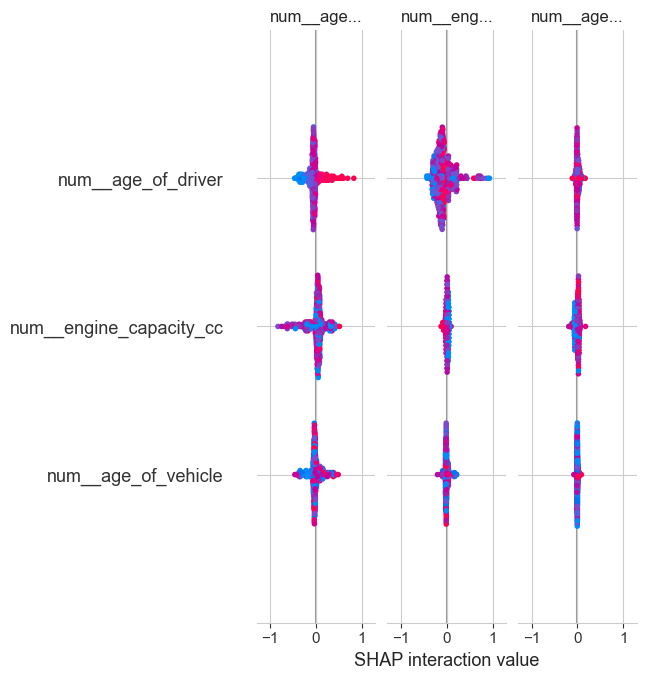

In [ ]:
import shap
print("\n=== SHAP global summary (main XGB) ===")
model_for_shap = None
# Prioritize specific trained models
if "xgb_main" in globals() and xgb_main is not None:
    model_for_shap = xgb_main.named_steps["clf"] if hasattr(xgb_main, "named_steps") else xgb_main
if model_for_shap is None and "weather_xgb" in globals() and weather_xgb is not None:
    model_for_shap = weather_xgb
if model_for_shap is None and "age_xgb" in globals() and age_xgb is not None:
    model_for_shap = age_xgb
# Fallback to general xgb_pipe if exists and other specifics don't
if model_for_shap is None and "xgb_pipe" in globals() and xgb_pipe is not None:
    model_for_shap = xgb_pipe.named_steps["clf"] if hasattr(xgb_pipe, "named_steps") else model_for_shap

if shap is None:
    print("shap not installed; skipping SHAP.")
elif model_for_shap is None:
    print("No suitable XGB model found for SHAP.")
else:
    try:
        # Prepare the raw data for preprocessing
        X_raw_for_shap = None
        # The xgb_pipe was retrained using X_train_raw_new in cell 670ec7e3
        if 'X_train_raw_new' in globals() and X_train_raw_new is not None:
            X_raw_for_shap = X_train_raw_new.copy()
        elif model_for_shap is age_xgb and 'df_dev' in globals() and 'age_feat_candidates' in globals():
            X_raw_for_shap = df_dev[age_feat_candidates].copy()
        elif model_for_shap is weather_xgb and 'df_w' in globals() and 'features_weather' in globals():
            X_raw_for_shap = df_w[features_weather].copy()

        if X_raw_for_shap is None:
            print("Could not identify the correct raw feature set for SHAP. Skipping.")
        else:
            # Ensure columns are present in X_raw_for_shap before transforming
            X_raw_for_shap_safe = ensure_columns_for_transform(X_raw_for_shap, numeric_feats + categorical_feats)

            # Transform using the global preprocessor
            X_proc_for_shap_array = preprocessor.transform(X_raw_for_shap_safe)

            # Dynamically determine the number of features from the transformed array
            actual_transformed_features = X_proc_for_shap_array.shape[1]
            print(f"Preprocessor output has {actual_transformed_features} columns.")

            # Get feature names from the preprocessor (should match actual_transformed_features)
            current_feature_names = []
            try:
                # get_feature_names_out from ColumnTransformer or its constituent transformers
                if hasattr(preprocessor, 'get_feature_names_out'):
                    current_feature_names = list(preprocessor.get_feature_names_out())
                else: # Fallback for older sklearn versions or complex cases
                    num_feats_out = numeric_feats # numerical features keep their names
                    cat_ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
                    if hasattr(cat_ohe, 'get_feature_names_out'):
                        cat_feats_out = list(cat_ohe.get_feature_names_out(categorical_feats))
                    else:
                        cat_feats_out = list(cat_ohe.get_feature_names(categorical_feats)) # Older API
                    current_feature_names = num_feats_out + cat_feats_out
            except Exception as e:
                print(f"Warning: Could not get feature names from preprocessor: {e}. Generating generic names.")
                current_feature_names = [f'f{i}' for i in range(actual_transformed_features)]

            if len(current_feature_names) != actual_transformed_features:
                print(f"Warning: Number of generated feature names ({len(current_feature_names)}) does not match actual transformed features ({actual_transformed_features}). Adjusting feature names for DataFrame.")
                current_feature_names = [f'f{i}' for i in range(actual_transformed_features)] # Force generic names if mismatch

            # Create DataFrame with correct feature names
            X_df_proc_for_shap = pd.DataFrame(X_proc_for_shap_array, columns=current_feature_names)

            print(f"SHAP input data prepared with {X_df_proc_for_shap.shape[1]} features and correct names.")

            # Sample for SHAP calculation
            Xs = X_df_proc_for_shap.sample(min(400, len(X_df_proc_for_shap)), random_state=RANDOM_STATE)

            # Initialize and run SHAP
            expl = shap.TreeExplainer(model_for_shap)
            shap_vals = expl.shap_values(Xs.values)

            if isinstance(shap_vals, list):
                # For multiclass, choose class 1 (serious) for summary plot by default
                cls_idx = 1 if len(shap_vals) > 1 else 0
                shap.summary_plot(shap_vals[cls_idx], Xs.values, feature_names=Xs.columns.tolist(), show=True)
            else:
                shap.summary_plot(shap_vals, Xs.values, feature_names=Xs.columns.tolist(), show=True)

    except Exception as e:
        print("SHAP failed:", e)


### Retrain XGBoost model with updated preprocessor

This step ensures that the `xgb_pipe` model, used for SHAP analysis and general evaluation, is trained with the latest feature engineering and preprocessing

In [ ]:


# Create X_train from train_fe (which is now mapped and engineered by the latest block)
train_model_new = train_fe.dropna(subset=["sev_std"]).copy()
y_train_new = train_model_new["sev_std"].astype(int)
X_train_raw_new = train_model_new[numeric_feats + categorical_feats].copy()

# Ensure columns for transform (fill missing if any)
X_train_raw_new = ensure_columns_for_transform(X_train_raw_new, numeric_feats + categorical_feats)

# XGBoost pipe using the globally available (and updated) preprocessor
xgb_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=RANDOM_STATE,
        n_jobs=-1 # Use all available cores
    ))
])
xgb_pipe.set_params(**{
    "clf__n_estimators": 250,
    "clf__learning_rate": 0.05,
    "clf__max_depth": 6
})

print("Retraining XGBoost model with updated preprocessor...")
print(f"X_train_raw_new shape: {X_train_raw_new.shape}")
xgb_pipe.fit(X_train_raw_new, y_train_new)

print("XGBoost model retraining complete.")

# Optionally, re-evaluate the retrained model on the test set if X_test_raw and y_test are available
if 'X_test_raw' in globals() and X_test_raw is not None and 'y_test' in globals() and y_test is not None:
    print("Evaluating retrained XGBoost model on test set...")
    # Ensure test data is also consistent
    test_model_new = test_fe.dropna(subset=["sev_std"]).copy()
    y_test_new = test_model_new["sev_std"].astype(int)
    X_test_raw_new = test_model_new[numeric_feats + categorical_feats].copy()
    X_test_raw_new = ensure_columns_for_transform(X_test_raw_new, numeric_feats + categorical_feats)

    preds = xgb_pipe.predict(X_test_raw_new)
    acc = accuracy_score(y_test_new, preds)
    f1w = f1_score(y_test_new, preds, average='weighted', zero_division=0)
    print(f"Retrained XGBoost Test Accuracy: {acc:.4f}, F1-weighted: {f1w:.4f}")

    # Update results dictionary
    if 'results' not in globals():
        results = {}
    results['xgboost_retrained'] = {'accuracy': float(acc), 'f1_weighted': float(f1w)}

    # Also update the original 'xgboost' entry in results if it exists, or create it
    if 'xgboost' in results and results['xgboost']['accuracy'] < acc:
        print("Retrained model performed better than previous XGBoost model. Updating entry.")
        results['xgboost'] = {'accuracy': float(acc), 'f1_weighted': float(f1w)}
    elif 'xgboost' not in results:
        results['xgboost'] = {'accuracy': float(acc), 'f1_weighted': float(f1w)}

    # Save the retrained pipeline
    if SAVE_ARTIFACTS:
        joblib.dump(xgb_pipe, ARTIFACTS / "xgboost_retrained.joblib")
        print("Retrained XGBoost model saved to artifacts.")

else:
    print("Test data (X_test_raw, y_test) not available for evaluation after retraining.")

Retraining XGBoost model with updated preprocessor...
X_train_raw_new shape: (2436197, 14)
XGBoost model retraining complete.
Evaluating retrained XGBoost model on test set...
Retrained XGBoost Test Accuracy: 0.7561, F1-weighted: 0.6598
Retrained XGBoost model saved to artifacts.



# Extended Analysis Module — When / Where / How / Which / Why



In [ ]:


# Prepare a sampled dataframe for plotting/analysis
try:
    train_fe['date'] = pd.to_datetime(train_fe['date'], errors='coerce', dayfirst=True)
except Exception:
    pass

# Ensure year/month/hour columns exist
if 'year' not in train_fe.columns and 'date' in train_fe.columns:
    train_fe['year'] = train_fe['date'].dt.year
if 'month' not in train_fe.columns and 'date' in train_fe.columns:
    train_fe['month'] = train_fe['date'].dt.month
if 'hour' not in train_fe.columns and 'time' in train_fe.columns:
    train_fe['hour'] = pd.to_datetime(train_fe['time'], format='%H:%M', errors='coerce').dt.hour

SAMP_N = min(150_000, len(train_fe))
sample_df = train_fe.sample(SAMP_N, random_state=42)
print(f"Using sample of {len(sample_df)} rows for interactive analysis")


Using sample of 150000 rows for interactive analysis


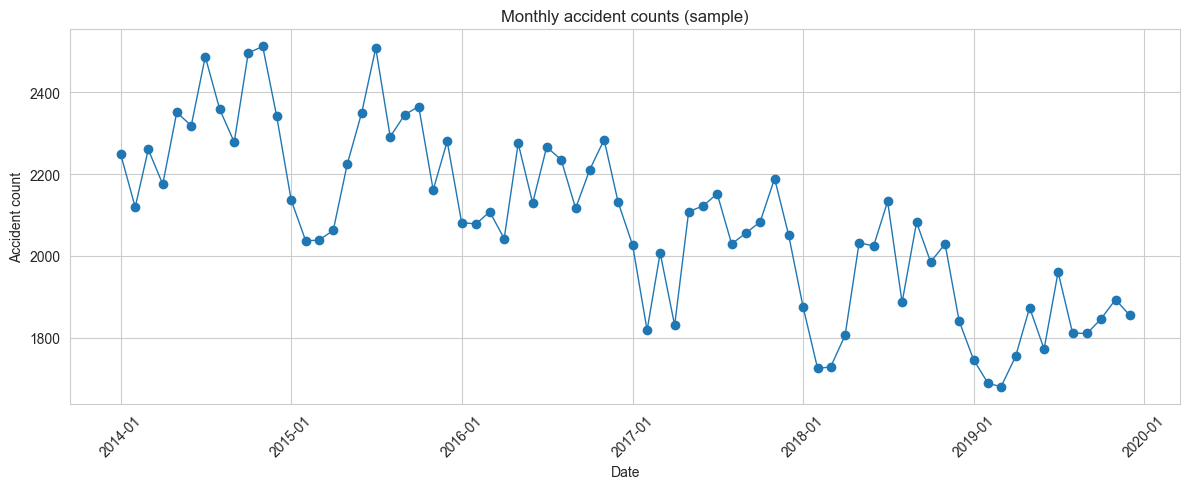

22:10:55 - cmdstanpy - INFO - Chain [1] start processing
22:10:56 - cmdstanpy - INFO - Chain [1] done processing


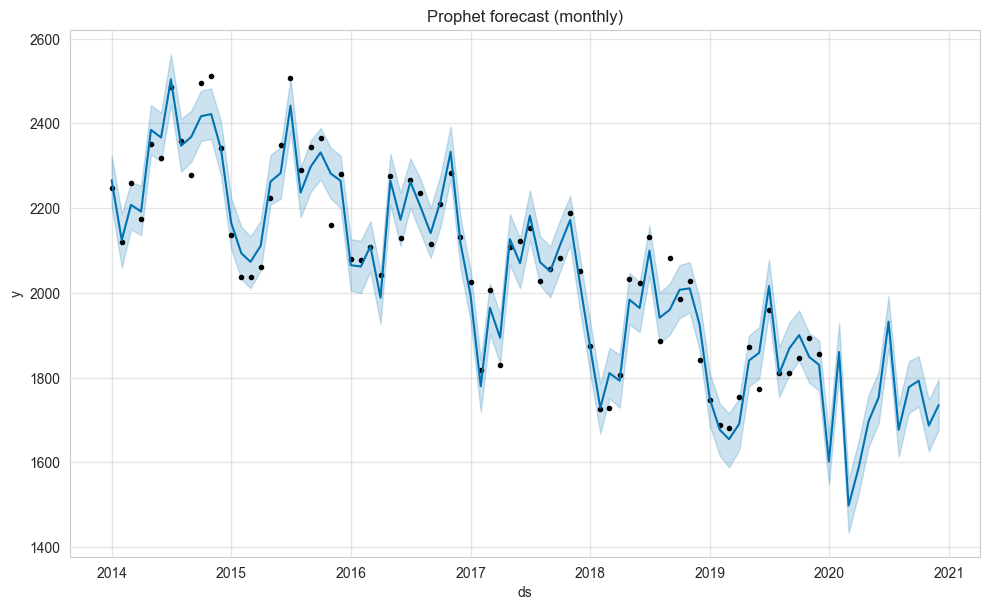

In [ ]:

# WHEN — Temporal trends & simple forecasting
import matplotlib.dates as mdates

# Monthly trend
monthly = sample_df.groupby(['year','month']).size().reset_index(name='accidents')
monthly = monthly.dropna(subset=['year','month'])
monthly['date'] = pd.to_datetime(monthly['year'].astype(str) + '-' + monthly['month'].astype(str) + '-01', errors='coerce')
monthly = monthly.sort_values('date')

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(monthly['date'], monthly['accidents'], marker='o', linewidth=1)
ax.set_title("Monthly accident counts (sample)")
ax.set_xlabel("Date"); ax.set_ylabel("Accident count")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Forecast with Prophet if available (short horizon)
if Prophet is not None:
    try:
        df_prop = monthly[['date','accidents']].rename(columns={'date':'ds','accidents':'y'}).dropna()
        m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(df_prop)
        future = m.make_future_dataframe(periods=12, freq='M')
        forecast = m.predict(future)
        fig2 = m.plot(forecast)
        plt.title("Prophet forecast (monthly)")
        plt.show()
    except Exception as e:
        print("Prophet forecast skipped:", e)
else:
    print("Prophet not installed — skip forecasting. Install with `pip install prophet`.")


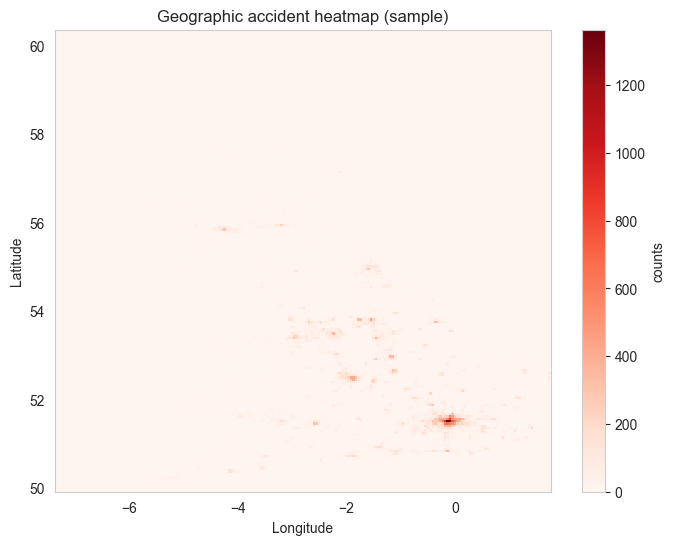

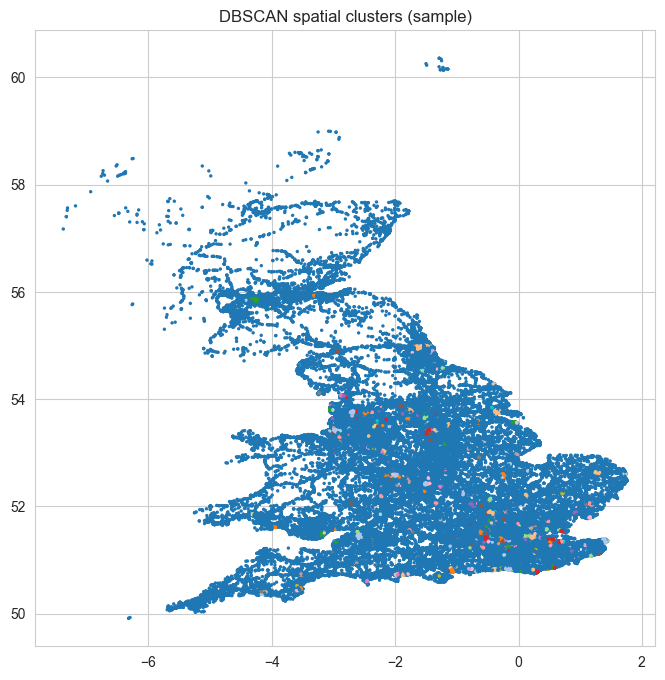

In [ ]:

# WHERE — Spatial hotspots and clustering
import numpy as np
import matplotlib.pyplot as plt

if ('latitude' in sample_df.columns) and ('longitude' in sample_df.columns):
    coords = sample_df[['latitude','longitude']].dropna()
    # Heatmap via 2D histogram
    fig, ax = plt.subplots(figsize=(8,6))
    H, xedges, yedges, im = ax.hist2d(coords['longitude'], coords['latitude'], bins=(200,200), cmap='Reds')
    ax.set_title("Geographic accident heatmap (sample)")
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    plt.colorbar(im, ax=ax, label='counts')
    plt.show()

    # DBSCAN clustering if sklearn available and sample small enough
    if DBSCAN is not None and len(coords) <= 200000:
        try:
            db = DBSCAN(eps=0.01, min_samples=30).fit(coords)
            clust = db.labels_
            coords_plot = coords.copy().reset_index(drop=True)
            coords_plot['cluster'] = clust
            fig, ax = plt.subplots(figsize=(8,8))
            sc = ax.scatter(coords_plot['longitude'], coords_plot['latitude'], c=coords_plot['cluster'], s=6, cmap='tab20', linewidth=0)
            ax.set_title('DBSCAN spatial clusters (sample)')
            plt.show()
        except Exception as e:
            print("DBSCAN clustering failed or OOM:", e)
    else:
        print("DBSCAN not available or sample too large; skip clustering.")
else:
    print("No latitude/longitude columns found; cannot run spatial analysis.")


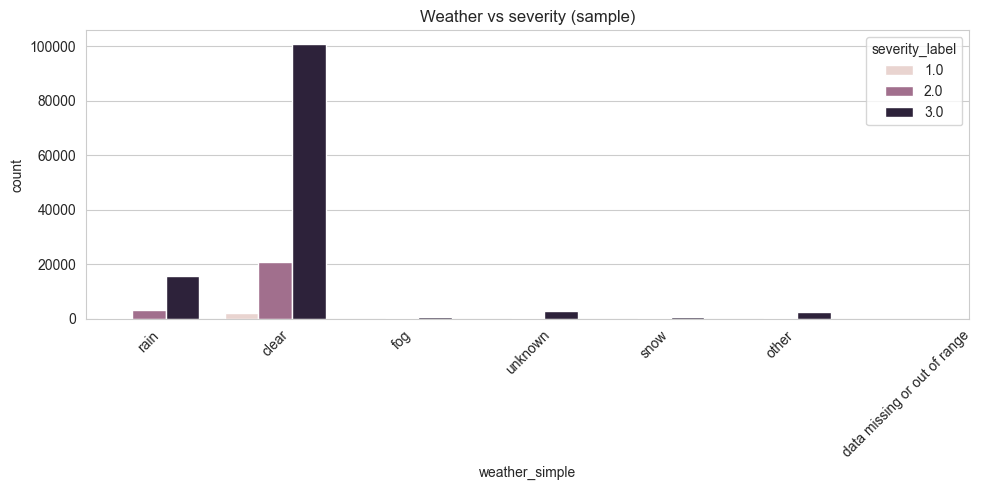

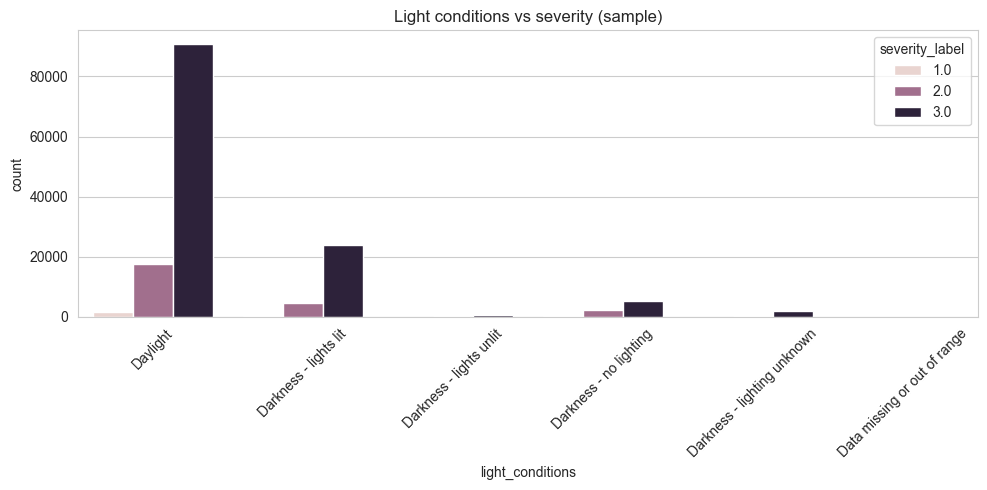

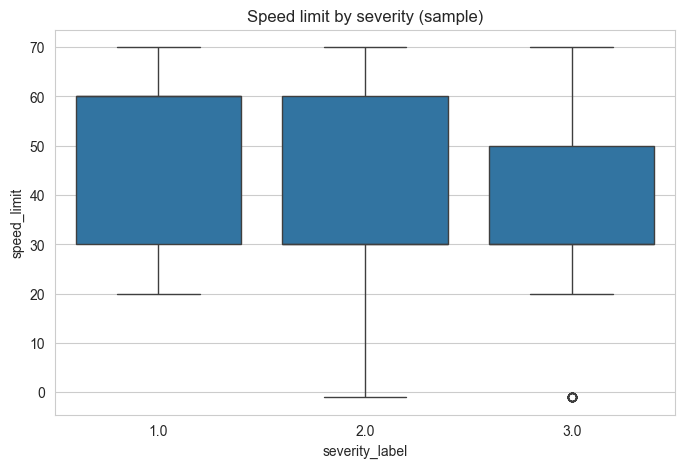

In [ ]:

# HOW — Interactions between weather/light/speed and severity (descriptive)
import seaborn as sns
import matplotlib.pyplot as plt

# Weather vs severity
if 'weather_simple' in sample_df.columns and 'severity_label' in sample_df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(x='weather_simple', hue='severity_label', data=sample_df)
    plt.title('Weather vs severity (sample)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('weather_simple or severity_label missing; skip weather analysis.')

# Light conditions vs severity
if 'light_conditions' in sample_df.columns and 'severity_label' in sample_df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(x='light_conditions', hue='severity_label', data=sample_df)
    plt.title('Light conditions vs severity (sample)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print('light_conditions missing; skip.')

# Speed limit distribution by severity
if 'speed_limit' in sample_df.columns and 'severity_label' in sample_df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='severity_label', y='speed_limit', data=sample_df)
    plt.title('Speed limit by severity (sample)')
    plt.show()
else:
    print('speed_limit or severity_label missing; skip.')


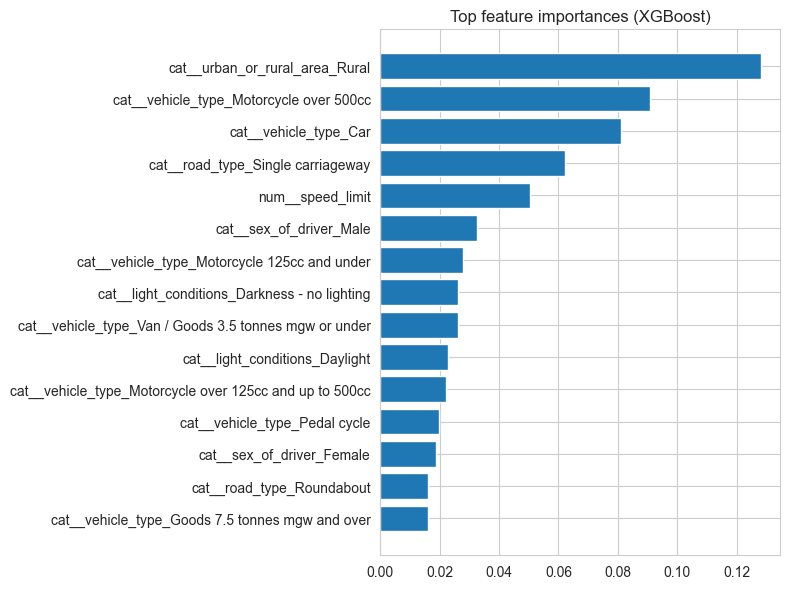

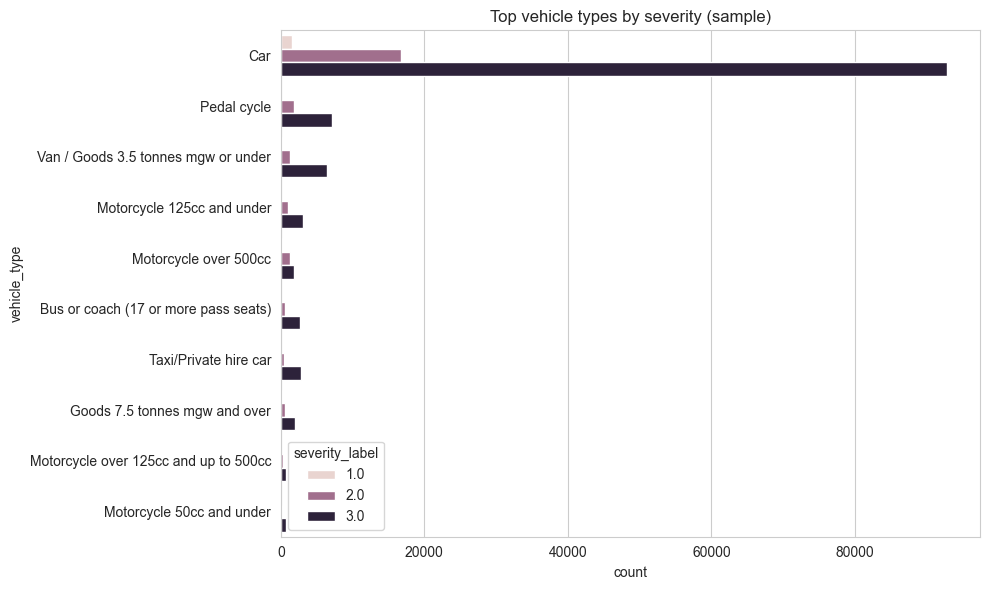

In [ ]:

# WHICH — Feature importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model-based importances (XGBoost)
try:
    if 'xgb_pipe' in globals():
        model = xgb_pipe.named_steps['clf']
        importances = model.feature_importances_
        feat_names = feature_names if 'feature_names' in globals() else [f'f{i}' for i in range(len(importances))]
        idx = np.argsort(importances)[::-1][:15]
        plt.figure(figsize=(8,6))
        plt.barh(np.array(feat_names)[idx][::-1], importances[idx][::-1])
        plt.title('Top feature importances (XGBoost)')
        plt.tight_layout()
        plt.show()
    else:
        print('xgb_pipe not found in notebook globals; skip model feature importances.')
except Exception as e:
    print('Feature importance extraction failed:', e)

# Segment analysis: vehicle_type vs severity
if 'vehicle_type' in sample_df.columns and 'severity_label' in sample_df.columns:
    top_vehicles = sample_df['vehicle_type'].value_counts().head(10).index.tolist()
    seg = sample_df[sample_df['vehicle_type'].isin(top_vehicles)]
    plt.figure(figsize=(10,6))
    sns.countplot(y='vehicle_type', hue='severity_label', data=seg, order=top_vehicles)
    plt.title('Top vehicle types by severity (sample)')
    plt.tight_layout()
    plt.show()
else:
    print('vehicle_type or severity_label missing; skip vehicle segment analysis.')


In [ ]:

# WHY — SHAP global summary and local explanations (if SHAP and model available)
try:
    if shap is None:
        print("shap not installed; skip SHAP analysis.")
    elif 'xgb_pipe' not in globals():
        print("xgb_pipe not available; skip SHAP analysis.")
    else:
        model_xgb = xgb_pipe.named_steps['clf']
        # prepare small processed dataset
        if 'X_test' in globals():
            X_proc = preprocessor.transform(X_test)  # numpy
            X_df_proc = pd.DataFrame(X_proc, columns=feature_names)
        else:
            # fallback: sample and transform from sample_df if features exist
            print("X_test not found — attempting to build from sample_df features")
            common_feats = [c for c in feature_names if c in sample_df.columns]
            if len(common_feats) > 0:
                X_df_proc = pd.DataFrame(preprocessor.transform(sample_df[common_feats]), columns=feature_names)
            else:
                raise ValueError("No matching features to create processed X for SHAP")
        # compute SHAP values for a small sample
        sample_n = min(2000, len(X_df_proc))
        X_s = X_df_proc.sample(sample_n, random_state=42)
        explainer = shap.TreeExplainer(model_xgb)
        shap_values = explainer.shap_values(X_s)
        shap.summary_plot(shap_values, X_s, show=True)
except Exception as e:
    print("SHAP analysis skipped or failed:", e)


SHAP analysis skipped or failed: columns are missing: {'age_band_of_driver'}


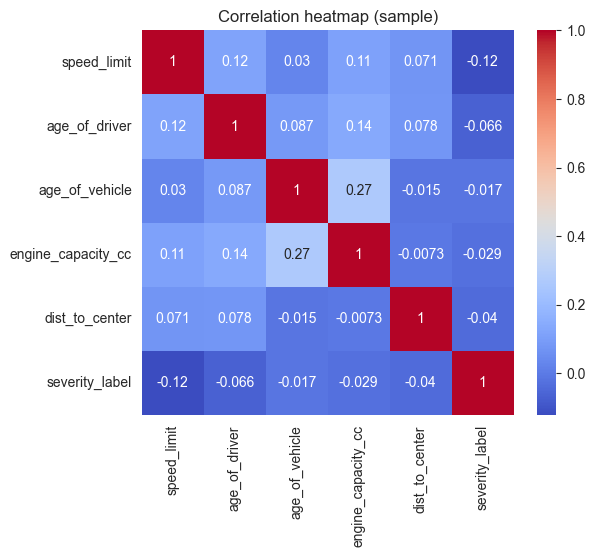

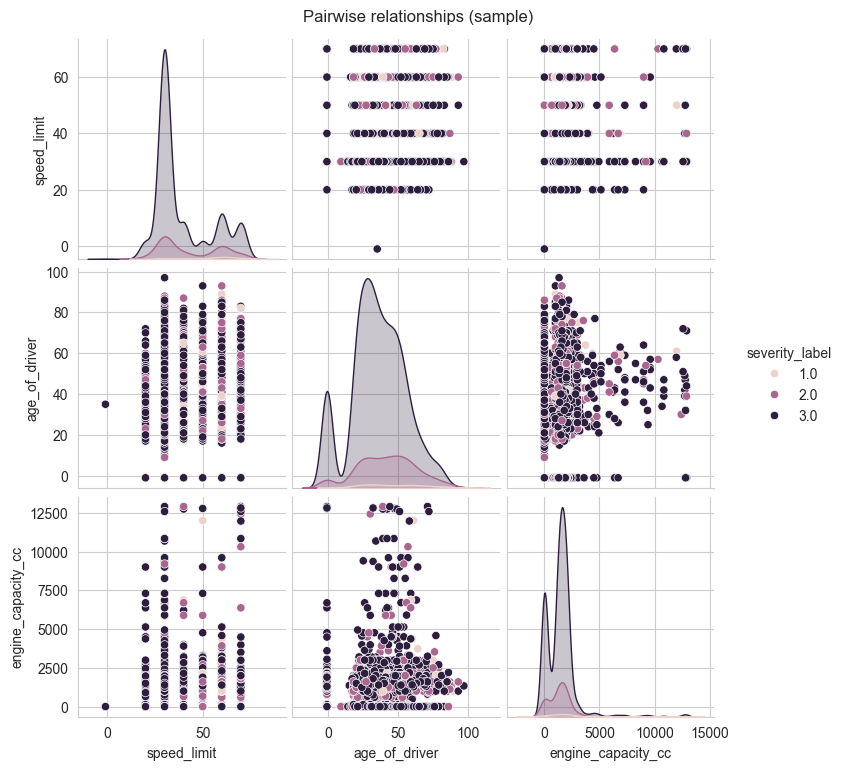

In [ ]:

# correlation heatmap and pairwise sample plot
try:
    corr_features = [c for c in ['speed_limit','age_of_driver','age_of_vehicle','engine_capacity_cc','dist_to_center','severity_label'] if c in sample_df.columns]
    if len(corr_features) >= 2:
        plt.figure(figsize=(6,5))
        sns.heatmap(sample_df[corr_features].corr(), annot=True, cmap='coolwarm')
        plt.title('Correlation heatmap (sample)')
        plt.show()

    pair_feats = [c for c in ['speed_limit','age_of_driver','engine_capacity_cc','severity_label'] if c in sample_df.columns]
    if len(pair_feats) >= 2:
        sns.pairplot(sample_df[pair_feats].sample(min(3000, len(sample_df))), hue='severity_label', diag_kind='kde')
        plt.suptitle('Pairwise relationships (sample)', y=1.02)
        plt.show()
except Exception as e:
    print('Correlation / pairplot skipped:', e)
